In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
#costume classes
from model import SentimentRNN
from model_utilities import train, test, predict
from preprocessing import clean_reviews, creat_vocab, tokenize_data, pad_features, train_test_split, google_clean_reviews, clean_reviews_and_creat_vocab

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meshari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# loading and exploring the data:

In [2]:
#loading the data
df_review = pd.read_pickle('yelp_dataset_reviews.pkl')
df_review.head(2)

,stars,text
0,positive,Apparently Prides Osteria had a rough summer a...
1,positive,This store is pretty good. Not as great as Wal...


In [3]:
df_review.shape

(8635403, 2)

In [4]:
#converting stars to 1/0 which is positive/negative 
df_review['stars'] = df_review['stars'].apply(lambda x:1 if x == 'positive' else 0 if x == 'negative' else None)
df_review.dropna(axis=0, inplace=True)
df_review.head(5)

,stars,text
0,1,Apparently Prides Osteria had a rough summer a...
1,1,This store is pretty good. Not as great as Wal...
2,1,I called WVM on the recommendation of a couple...
3,0,I've stayed at many Marriott and Renaissance M...
4,1,The food is always great here. The service fro...


<BarContainer object of 2 artists>

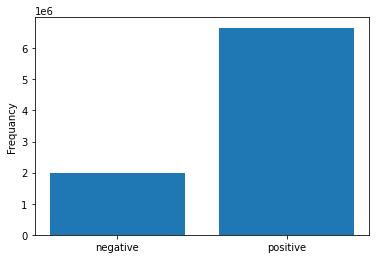

In [5]:
#plotting the pos/neg distrubution
plt.figure()

plt.ylabel('Frequancy')
plt.xticks([1, 0],['positive','negative'])

plt.bar([1, 0], df_review['stars'].value_counts())

# getting rid of outliers (reviews that are long or small) :

In [6]:
def clean_reviews1(reviews, punct=True, stopwords_=False, stemm=False):
    
    token_dict = {'.': '||*Period*||', ',': '||*Comma*||', '"': '||*Quotation_Mark*||', 
                ';': '||*Semicolon*||', '!': '||*Exclamation_mark*||', '?': '||*Question_mark*||',
                '(': '||*Left_Parentheses*||', ')':'||*Right_Parentheses*||', '-': '||*Dash*||', '\n': '||*Return*||'}

    for i in range(len(reviews)):
        #lower case all charcters to normalize them 
        reviews[i] = reviews[i].lower()
                    
        #replace punctuation with token_dict values speceifed above 
        #while putting space as to not create multiple instance of the same word 
        #for example eating. would be treated as a new word diffrent from eating
        if punct:
            for key, token in token_dict.items():
                reviews[i] = reviews[i].replace(key, ' {} '.format(token))
        else:
            reviews[i] = ''.join([c for c in reviews[i] if c not in punctuation])#remove punctuation
            
            
        return reviews

In [7]:
def tokenize_data1(reviews, vocab_to_int):
    # encoding reviews
    reviews_arrays = []
    for review in reviews:
        words = review.split()
        reviews_arrays.append([vocab_to_int.get(word, 0) for word in words])

    return reviews_arrays

In [8]:
reviews_strings = list(df_review['text'])
print(len(reviews_strings))

# make sure the reviews is cleaned so that punctionations would be considred as a word of it's own
reviews_strings = clean_reviews1(reviews_strings)
print(len(reviews_strings))

# make the vocab an empty dictinary to save space and time 
vocab_to_int = {}

# tokinezing each review is an array with tokiniezed word 
# for example: the food was good ---> [342, 4524, 521, 11] 
# since the vocab is empty it would actually be [0, 0 , 0, 0]
# but that okay since we are intrested in the length of the review and not it's tockienezd value
reviews_arrays = tokenize_data1(reviews_strings, vocab_to_int)
print(len(reviews_arrays))
reviews_strings = None
labels = None

8635403
8635403
8635403


In [9]:
# counting the reviews lengths and adding them as a new column to the dataframe
df_review['lengths'] = [len(reviews) for reviews in reviews_arrays]
reviews_arrays = None
df_review

,stars,text,lengths
0,1,Apparently Prides Osteria had a rough summer a...,350
1,1,This store is pretty good. Not as great as Wal...,122
2,1,I called WVM on the recommendation of a couple...,114
3,0,I've stayed at many Marriott and Renaissance M...,72
4,1,The food is always great here. The service fro...,36
...,...,...,...
8635398,0,"In December, I called in (as a returning custo...",459
8635399,0,This guy is a moron that will stalk and harass...,75
8635400,1,"Yummy, great chew on the bagel\nFriendly staff...",14
8635401,0,This used to be my car wash of choice. They di...,281


In [10]:
# # testing the appropriate upper length to delete 
# condition = df_review['lengths'] > 400
# print(condition.value_counts()

In [11]:
# df_review.drop(df_review[condition].index, inplace=True)

In [12]:
# df_review.shape

In [13]:
# # testing the appropriate lower length to delete
# condition = df_review['lengths'] < 5
# print(condition.value_counts())

In [14]:
# df_review.drop(df_review[condition].index, inplace=True)

In [15]:
# df_review.shape

# balancing the data distrubution (so that the positive reviews would equal the negative ones) :

In [16]:
def balance_distrubution(df, pos_percentage = 0.5):
    if df['stars'].sum(axis=0)/len(df) < pos_percentage:
        print('positive percentage is already below {}%'.format(pos_percentage*100))
        return
    
    df = df.reset_index(drop=True) 
    #sorting the values by the label so that the positive (1) would come first 
    df = df.sort_values(by='stars', ascending=False)
    #taking an estimation of 1% if the total length of the dataframe
    step = int(len(df)/100)
    
    for i in range(0, df.shape[0], step):
        #dropping the amount of step of entries until the pos_percentage reaches 1% obave it
        #so that no more data than required would be deleted
        if (df['stars'].sum(axis=0)/len(df)) > (pos_percentage+0.01):
            df.drop(df.index[0:step], axis=0, inplace=True)
            df = df.reset_index(drop=True)
            print(df['stars'].sum(axis=0)/len(df))
        elif (df['stars'].sum(axis=0)/len(df)) > pos_percentage:
            #taking an estimation of the remaining data and dropping them
            remaining_data = int(((df['stars'].sum(axis=0)/len(df)) - pos_percentage) * len(df))
            df.drop(df.index[0:remaining_data], axis=0, inplace=True)
#taking the positive reviews from the end to get rid of very short reviews if the data is ordred
#             postive_last_index = int(len(df)/2)-remaining_data
#             df.drop(df.index[postive_last_index-remaining_data:postive_last_index], axis=0, inplace=True)
            df = df.reset_index(drop=True)  
            print(df['stars'].sum(axis=0)/len(df))
            #dropping entries one by one until it reaches pos_percentage 
            for i in range(df.shape[0]):
                if (df['stars'].sum(axis=0)/len(df)) > pos_percentage:
                    df.drop(df.index[0], axis=0, inplace=True)
                    df = df.reset_index(drop=True)
                    print(df['stars'].sum(axis=0)/len(df))
                else:
                    break        
        elif (df['stars'].sum(axis=0)/len(df)) >= pos_percentage - 0.00001:        
            return df
        
        else:
            raise Exception()

In [17]:
balance_distrubution(df_review, pos_percentage=0.95)

positive percentage is already below 95.0%


In [18]:
df_review = balance_distrubution(df_review, pos_percentage=0.6)

0.7690763031069304
0.7667199396882435
0.764314991474201
0.7618599401904973
0.7593532036355113
0.756793132279918
0.7541780056469212
0.7515060284564138
0.7487753265149079
0.745983942331459
0.743129830438036
0.7402108523908251
0.7372247714267954
0.7341692467474689
0.7310418273991897
0.7278399457162713
0.7245609102901547
0.7212018984241136
0.7177599480290512
0.7142319489114797
0.7106146333998293
0.706904566249704
0.7030981337625339
0.6991915320451745
0.6951807543302742
0.691061577268564
0.6868295460944868
0.6824799585556296
0.67800784748408
0.6734079618739002
0.668674746313164
0.6638023186011759
0.6587844453612609
0.6536145154365388
0.6482855108299233
0.6427899749197481
0.637119977648312
0.6312670773415745
0.6252222787734142
0.6189759870363154
0.6125179567209413
0.6058372358384239
0.6035229055334898
0.6035228259083911
0.6035227462832604
0.6035226666580978
0.6035225870329033
0.6035225074076767
0.6035224277824182
0.6035223481571276
0.603522268531805
0.6035221889064505
0.603522109281064
0.603

0.603491690043618
0.6034916104059808
0.6034915307683115
0.6034914511306103
0.603491371492877
0.6034912918551119
0.6034912122173146
0.6034911325794854
0.6034910529416242
0.603490973303731
0.6034908936658059
0.6034908140278488
0.6034907343898596
0.6034906547518385
0.6034905751137853
0.6034904954757002
0.6034904158375831
0.603490336199434
0.6034902565612529
0.6034901769230399
0.6034900972847947
0.6034900176465177
0.6034899380082087
0.6034898583698676
0.6034897787314946
0.6034896990930896
0.6034896194546525
0.6034895398161836
0.6034894601776826
0.6034893805391496
0.6034893009005846
0.6034892212619877
0.6034891416233586
0.6034890619846978
0.6034889823460048
0.6034889027072798
0.6034888230685229
0.603488743429734
0.6034886637909131
0.6034885841520603
0.6034885045131754
0.6034884248742585
0.6034883452353097
0.6034882655963288
0.6034881859573159
0.6034881063182711
0.6034880266791943
0.6034879470400855
0.6034878674009446
0.6034877877617719
0.6034877081225671
0.6034876284833303
0.603487548844061

0.6034570446514513
0.6034569649998965
0.6034568853483098
0.6034568056966911
0.6034567260450404
0.6034566463933576
0.6034565667416429
0.6034564870898962
0.6034564074381175
0.6034563277863068
0.603456248134464
0.6034561684825893
0.6034560888306826
0.6034560091787439
0.6034559295267732
0.6034558498747704
0.6034557702227358
0.6034556905706691
0.6034556109185703
0.6034555312664396
0.6034554516142769
0.6034553719620822
0.6034552923098555
0.6034552126575968
0.6034551330053061
0.6034550533529833
0.6034549737006286
0.6034548940482419
0.6034548143958233
0.6034547347433725
0.6034546550908899
0.6034545754383752
0.6034544957858284
0.6034544161332498
0.6034543364806391
0.6034542568279965
0.6034541771753217
0.603454097522615
0.6034540178698764
0.6034539382171057
0.603453858564303
0.6034537789114683
0.6034536992586016
0.6034536196057029
0.6034535399527723
0.6034534602998095
0.6034533806468149
0.6034533009937882
0.6034532213407295
0.6034531416876389
0.6034530620345162
0.6034529823813615
0.6034529027281

0.6034223932043896
0.6034223135389137
0.6034222338734059
0.603422154207866
0.6034220745422941
0.6034219948766902
0.6034219152110544
0.6034218355453864
0.6034217558796865
0.6034216762139546
0.6034215965481907
0.6034215168823948
0.6034214372165668
0.6034213575507069
0.6034212778848149
0.603421198218891
0.603421118552935
0.603421038886947
0.6034209592209271
0.603420879554875
0.603420799888791
0.603420720222675
0.603420640556527
0.603420560890347
0.603420481224135
0.603420401557891
0.603420321891615
0.6034202422253069
0.6034201625589668
0.6034200828925947
0.6034200032261907
0.6034199235597546
0.6034198438932866
0.6034197642267864
0.6034196845602544
0.6034196048936903
0.6034195252270942
0.603419445560466
0.603419365893806
0.6034192862271138
0.6034192065603896
0.6034191268936335
0.6034190472268454
0.6034189675600252
0.603418887893173
0.6034188082262888
0.6034187285593726
0.6034186488924245
0.6034185692254442
0.603418489558432
0.6034184098913878
0.6034183302243116
0.6034182505572033
0.6034181

0.6033877357008455
0.6033876560214448
0.6033875763420122
0.6033874966625475
0.6033874169830509
0.6033873373035221
0.6033872576239614
0.6033871779443687
0.603387098264744
0.6033870185850873
0.6033869389053984
0.6033868592256777
0.6033867795459248
0.60338669986614
0.6033866201863232
0.6033865405064743
0.6033864608265934
0.6033863811466805
0.6033863014667357
0.6033862217867587
0.6033861421067498
0.6033860624267089
0.6033859827466359
0.603385903066531
0.6033858233863939
0.6033857437062249
0.6033856640260239
0.6033855843457909
0.6033855046655258
0.6033854249852287
0.6033853453048996
0.6033852656245385
0.6033851859441455
0.6033851062637203
0.6033850265832632
0.603384946902774
0.6033848672222528
0.6033847875416996
0.6033847078611144
0.6033846281804972
0.6033845484998479
0.6033844688191666
0.6033843891384534
0.603384309457708
0.6033842297769307
0.6033841500961215
0.6033840704152801
0.6033839907344067
0.6033839110535014
0.603383831372564
0.6033837516915945
0.6033836720105932
0.6033835923295597


0.6033530721392311
0.6033529924459019
0.6033529127525409
0.6033528330591478
0.6033527533657226
0.6033526736722654
0.6033525939787763
0.603352514285255
0.6033524345917018
0.6033523548981166
0.6033522752044993
0.60335219551085
0.6033521158171686
0.6033520361234553
0.60335195642971
0.6033518767359325
0.603351797042123
0.6033517173482816
0.6033516376544081
0.6033515579605027
0.6033514782665652
0.6033513985725956
0.6033513188785941
0.6033512391845605
0.6033511594904949
0.6033510797963972
0.6033510001022675
0.6033509204081059
0.6033508407139121
0.6033507610196864
0.6033506813254287
0.6033506016311388
0.603350521936817
0.6033504422424633
0.6033503625480774
0.6033502828536595
0.6033502031592096
0.6033501234647277
0.6033500437702137
0.6033499640756678
0.6033498843810897
0.6033498046864797
0.6033497249918377
0.6033496452971636
0.6033495656024574
0.6033494859077193
0.6033494062129492
0.603349326518147
0.6033492468233128
0.6033491671284467
0.6033490874335484
0.6033490077386181
0.6033489280436558
0

0.6033184822251867
0.6033184025179575
0.6033183228106964
0.6033182431034032
0.603318163396078
0.6033180836887208
0.6033180039813315
0.6033179242739102
0.6033178445664569
0.6033177648589715
0.6033176851514541
0.6033176054439047
0.6033175257363231
0.6033174460287096
0.6033173663210641
0.6033172866133866
0.603317206905677
0.6033171271979354
0.6033170474901617
0.603316967782356
0.6033168880745182
0.6033168083666485
0.6033167286587467
0.6033166489508129
0.603316569242847
0.6033164895348492
0.6033164098268192
0.6033163301187573
0.6033162504106633
0.6033161707025373
0.6033160909943792
0.6033160112861892
0.603315931577967
0.6033158518697128
0.6033157721614267
0.6033156924531085
0.6033156127447582
0.603315533036376
0.6033154533279617
0.6033153736195153
0.6033152939110369
0.6033152142025265
0.6033151344939841
0.6033150547854096
0.6033149750768031
0.6033148953681645
0.603314815659494
0.6033147359507913
0.6033146562420567
0.60331457653329
0.6033144968244913
0.6033144171156606
0.6033143374067979
0.

0.6032838862777337
0.603283806556601
0.6032837268354361
0.6032836471142392
0.6032835673930103
0.6032834876717493
0.6032834079504563
0.6032833282291312
0.6032832485077742
0.603283168786385
0.6032830890649639
0.6032830093435106
0.6032829296220255
0.6032828499005082
0.6032827701789588
0.6032826904573775
0.6032826107357641
0.6032825310141186
0.6032824512924411
0.6032823715707315
0.60328229184899
0.6032822121272163
0.6032821324054107
0.603282052683573
0.6032819729617033
0.6032818932398015
0.6032818135178677
0.6032817337959019
0.6032816540739039
0.603281574351874
0.6032814946298121
0.603281414907718
0.6032813351855919
0.6032812554634338
0.6032811757412437
0.6032810960190215
0.6032810162967672
0.603280936574481
0.6032808568521627
0.6032807771298123
0.60328069740743
0.6032806176850155
0.6032805379625691
0.6032804582400906
0.60328037851758
0.6032802987950374
0.6032802190724628
0.603280139349856
0.6032800596272173
0.6032799799045466
0.6032799001818437
0.603279820459109
0.603279740736342
0.603279

0.6032492045602532
0.6032491248251811
0.6032490450900768
0.6032489653549405
0.6032488856197723
0.6032488058845719
0.6032487261493394
0.603248646414075
0.6032485666787785
0.6032484869434499
0.6032484072080893
0.6032483274726966
0.6032482477372719
0.6032481680018151
0.6032480882663264
0.6032480085308055
0.6032479287952526
0.6032478490596677
0.6032477693240507
0.6032476895884016
0.6032476098527204
0.6032475301170073
0.6032474503812622
0.6032473706454848
0.6032472909096755
0.6032472111738342
0.6032471314379608
0.6032470517020554
0.6032469719661179
0.6032468922301483
0.6032468124941467
0.603246732758113
0.6032466530220474
0.6032465732859497
0.6032464935498199
0.603246413813658
0.6032463340774641
0.6032462543412381
0.6032461746049802
0.6032460948686901
0.603246015132368
0.6032459353960139
0.6032458556596277
0.6032457759232095
0.6032456961867592
0.6032456164502769
0.6032455367137625
0.603245456977216
0.6032453772406375
0.603245297504027
0.6032452177673844
0.6032451380307098
0.6032450582940031

0.6032145965273353
0.6032145167783521
0.603214437029337
0.6032143572802897
0.6032142775312104
0.6032141977820991
0.6032141180329555
0.6032140382837801
0.6032139585345725
0.603213878785333
0.6032137990360613
0.6032137192867576
0.6032136395374218
0.6032135597880539
0.603213480038654
0.6032134002892221
0.6032133205397581
0.6032132407902621
0.6032131610407339
0.6032130812911737
0.6032130015415815
0.6032129217919572
0.6032128420423009
0.6032127622926124
0.603212682542892
0.6032126027931395
0.6032125230433548
0.6032124432935382
0.6032123635436896
0.6032122837938088
0.603212204043896
0.6032121242939511
0.6032120445439741
0.6032119647939652
0.6032118850439241
0.603211805293851
0.6032117255437459
0.6032116457936086
0.6032115660434394
0.6032114862932381
0.6032114065430046
0.6032113267927393
0.6032112470424417
0.6032111672921121
0.6032110875417506
0.6032110077913568
0.6032109280409311
0.6032108482904733
0.6032107685399835
0.6032106887894616
0.6032106090389076
0.6032105292883215
0.6032104495377034

0.6031799824562672
0.6031799026933695
0.6031798229304397
0.6031797431674778
0.6031796634044838
0.6031795836414579
0.6031795038783998
0.6031794241153096
0.6031793443521873
0.6031792645890331
0.6031791848258468
0.6031791050626283
0.6031790252993778
0.6031789455360953
0.6031788657727807
0.603178786009434
0.6031787062460553
0.6031786264826444
0.6031785467192016
0.6031784669557266
0.6031783871922196
0.6031783074286805
0.6031782276651094
0.6031781479015061
0.6031780681378709
0.6031779883742036
0.6031779086105041
0.6031778288467727
0.6031777490830091
0.6031776693192136
0.6031775895553859
0.6031775097915262
0.6031774300276344
0.6031773502637106
0.6031772704997546
0.6031771907357666
0.6031771109717465
0.6031770312076944
0.6031769514436102
0.603176871679494
0.6031767919153456
0.6031767121511652
0.6031766323869527
0.6031765526227082
0.6031764728584316
0.603176393094123
0.6031763133297822
0.6031762335654094
0.6031761538010045
0.6031760740365676
0.6031759942720987
0.6031759145075976
0.6031758347430

0.6031453623454688
0.6031452825686527
0.6031452027918047
0.6031451230149245
0.6031450432380123
0.6031449634610679
0.6031448836840916
0.6031448039070831
0.6031447241300426
0.60314464435297
0.6031445645758653
0.6031444847987286
0.6031444050215597
0.6031443252443588
0.6031442454671259
0.6031441656898608
0.6031440859125636
0.6031440061352344
0.6031439263578732
0.6031438465804798
0.6031437668030545
0.603143687025597
0.6031436072481073
0.6031435274705857
0.603143447693032
0.6031433679154462
0.6031432881378284
0.6031432083601784
0.6031431285824964
0.6031430488047823
0.6031429690270361
0.6031428892492579
0.6031428094714476
0.6031427296936052
0.6031426499157307
0.6031425701378241
0.6031424903598855
0.6031424105819149
0.6031423308039121
0.6031422510258773
0.6031421712478103
0.6031420914697113
0.6031420116915803
0.6031419319134171
0.603141852135222
0.6031417723569946
0.6031416925787353
0.6031416128004439
0.6031415330221204
0.6031414532437648
0.6031413734653771
0.6031412936869573
0.603141213908505

0.6031107361933589
0.603110656402621
0.603110576611851
0.6031104968210489
0.6031104170302147
0.6031103372393485
0.6031102574484501
0.6031101776575198
0.6031100978665573
0.6031100180755627
0.6031099382845361
0.6031098584934773
0.6031097787023865
0.6031096989112636
0.6031096191201086
0.6031095393289215
0.6031094595377025
0.6031093797464512
0.6031092999551678
0.6031092201638525
0.603109140372505
0.6031090605811255
0.6031089807897138
0.6031089009982701
0.6031088212067942
0.6031087414152864
0.6031086616237463
0.6031085818321743
0.6031085020405702
0.6031084222489339
0.6031083424572656
0.6031082626655653
0.6031081828738327
0.6031081030820682
0.6031080232902716
0.6031079434984429
0.603107863706582
0.6031077839146891
0.6031077041227642
0.6031076243308071
0.603107544538818
0.6031074647467968
0.6031073849547435
0.6031073051626581
0.6031072253705406
0.6031071455783911
0.6031070657862094
0.6031069859939957
0.6031069062017499
0.603106826409472
0.603106746617162
0.60310666682482
0.6031065870324458
0.

0.6030761039983562
0.6030760241936927
0.6030759443889971
0.6030758645842695
0.6030757847795097
0.603075704974718
0.6030756251698941
0.603075545365038
0.6030754655601499
0.6030753857552298
0.6030753059502775
0.6030752261452932
0.6030751463402767
0.6030750665352281
0.6030749867301475
0.6030749069250347
0.6030748271198899
0.603074747314713
0.603074667509504
0.6030745877042629
0.6030745078989898
0.6030744280936845
0.6030743482883472
0.6030742684829776
0.6030741886775761
0.6030741088721425
0.6030740290666767
0.603073949261179
0.603073869455649
0.603073789650087
0.6030737098444929
0.6030736300388667
0.6030735502332084
0.6030734704275181
0.6030733906217957
0.6030733108160411
0.6030732310102545
0.6030731512044357
0.6030730713985849
0.603072991592702
0.6030729117867869
0.6030728319808398
0.6030727521748607
0.6030726723688493
0.603072592562806
0.6030725127567306
0.603072432950623
0.6030723531444833
0.6030722733383116
0.6030721935321077
0.6030721137258718
0.6030720339196038
0.6030719541133037
0.6

0.6030414657588785
0.6030413859402859
0.6030413061216611
0.6030412263030043
0.6030411464843153
0.6030410666655943
0.6030409868468412
0.6030409070280559
0.6030408272092386
0.6030407473903892
0.6030406675715075
0.603040587752594
0.6030405079336482
0.6030404281146704
0.6030403482956604
0.6030402684766184
0.6030401886575443
0.6030401088384381
0.6030400290192997
0.6030399492001293
0.6030398693809267
0.6030397895616921
0.6030397097424254
0.6030396299231265
0.6030395501037956
0.6030394702844326
0.6030393904650374
0.6030393106456102
0.6030392308261509
0.6030391510066595
0.603039071187136
0.6030389913675803
0.6030389115479926
0.6030388317283727
0.6030387519087208
0.6030386720890368
0.6030385922693207
0.6030385124495724
0.6030384326297921
0.6030383528099796
0.6030382729901351
0.6030381931702585
0.6030381133503498
0.603038033530409
0.6030379537104361
0.6030378738904311
0.6030377940703939
0.6030377142503247
0.6030376344302234
0.6030375546100899
0.6030374747899244
0.6030373949697267
0.6030373151494

0.6030067416408178
0.6030066618082602
0.6030065819756706
0.6030065021430487
0.6030064223103948
0.6030063424777088
0.6030062626449907
0.6030061828122405
0.6030061029794581
0.6030060231466436
0.6030059433137971
0.6030058634809184
0.6030057836480077
0.6030057038150648
0.6030056239820898
0.6030055441490827
0.6030054643160435
0.6030053844829723
0.6030053046498688
0.6030052248167332
0.6030051449835656
0.6030050651503659
0.603004985317134
0.6030049054838701
0.603004825650574
0.6030047458172458
0.6030046659838856
0.6030045861504931
0.6030045063170686
0.6030044264836121
0.6030043466501234
0.6030042668166025
0.6030041869830496
0.6030041071494645
0.6030040273158473
0.6030039474821981
0.6030038676485168
0.6030037878148032
0.6030037079810577
0.60300362814728
0.6030035483134703
0.6030034684796283
0.6030033886457543
0.6030033088118482
0.6030032289779099
0.6030031491439396
0.6030030693099372
0.6030029894759026
0.6030029096418359
0.6030028298077371
0.6030027499736063
0.6030026701394433
0.60300259030524

0.6029720114472115
0.6029719316006853
0.602971851754127
0.6029717719075366
0.602971692060914
0.6029716122142593
0.6029715323675726
0.6029714525208537
0.6029713726741027
0.6029712928273195
0.6029712129805043
0.6029711331336569
0.6029710532867775
0.6029709734398658
0.6029708935929222
0.6029708137459463
0.6029707338989384
0.6029706540518983
0.6029705742048261
0.6029704943577219
0.6029704145105855
0.602970334663417
0.6029702548162164
0.6029701749689835
0.6029700951217187
0.6029700152744217
0.6029699354270927
0.6029698555797314
0.6029697757323381
0.6029696958849127
0.602969616037455
0.6029695361899654
0.6029694563424436
0.6029693764948897
0.6029692966473036
0.6029692167996855
0.6029691369520352
0.6029690571043528
0.6029689772566383
0.6029688974088917
0.602968817561113
0.6029687377133021
0.6029686578654592
0.6029685780175841
0.6029684981696769
0.6029684183217375
0.6029683384737661
0.6029682586257625
0.6029681787777269
0.6029680989296591
0.6029680190815592
0.6029679392334272
0.602967859385263

0.6029372751764648
0.6029371953159663
0.6029371154554357
0.602937035594873
0.6029369557342782
0.6029368758736512
0.6029367960129921
0.6029367161523008
0.6029366362915776
0.602936556430822
0.6029364765700345
0.6029363967092147
0.6029363168483629
0.6029362369874789
0.6029361571265629
0.6029360772656146
0.6029359974046343
0.6029359175436219
0.6029358376825772
0.6029357578215006
0.6029356779603917
0.6029355980992507
0.6029355182380777
0.6029354383768724
0.6029353585156351
0.6029352786543656
0.602935198793064
0.6029351189317304
0.6029350390703645
0.6029349592089666
0.6029348793475364
0.6029347994860742
0.6029347196245799
0.6029346397630534
0.6029345599014948
0.6029344800399041
0.6029344001782813
0.6029343203166263
0.6029342404549393
0.60293416059322
0.6029340807314687
0.6029340008696852
0.6029339210078696
0.6029338411460219
0.602933761284142
0.6029336814222301
0.602933601560286
0.6029335216983098
0.6029334418363015
0.602933361974261
0.6029332821121884
0.6029332022500836
0.6029331223879468
0

0.6029025328269825
0.6029024529525081
0.6029023730780015
0.6029022932034629
0.602902213328892
0.6029021334542891
0.602902053579654
0.6029019737049868
0.6029018938302875
0.602901813955556
0.6029017340807924
0.6029016542059966
0.6029015743311688
0.6029014944563087
0.6029014145814166
0.6029013347064923
0.6029012548315359
0.6029011749565474
0.6029010950815267
0.6029010152064739
0.6029009353313889
0.6029008554562718
0.6029007755811226
0.6029006957059413
0.6029006158307278
0.6029005359554822
0.6029004560802045
0.6029003762048946
0.6029002963295526
0.6029002164541785
0.6029001365787722
0.6029000567033338
0.6028999768278632
0.6028998969523606
0.6028998170768257
0.6028997372012588
0.6028996573256598
0.6028995774500285
0.6028994975743651
0.6028994176986697
0.602899337822942
0.6028992579471824
0.6028991780713905
0.6028990981955664
0.6028990183197103
0.602898938443822
0.6028988585679016
0.6028987786919491
0.6028986988159644
0.6028986189399476
0.6028985390638986
0.6028984591878175
0.602898379311704

0.6028678642855907
0.6028677843971688
0.6028677045087149
0.6028676246202286
0.6028675447317103
0.6028674648431599
0.6028673849545773
0.6028673050659625
0.6028672251773156
0.6028671452886366
0.6028670653999255
0.6028669855111822
0.6028669056224067
0.6028668257335992
0.6028667458447594
0.6028666659558876
0.6028665860669835
0.6028665061780474
0.6028664262890792
0.6028663464000787
0.6028662665110461
0.6028661866219814
0.6028661067328845
0.6028660268437556
0.6028659469545944
0.6028658670654011
0.6028657871761757
0.6028657072869181
0.6028656273976284
0.6028655475083066
0.6028654676189525
0.6028653877295664
0.6028653078401481
0.6028652279506977
0.6028651480612152
0.6028650681717005
0.6028649882821536
0.6028649083925747
0.6028648285029635
0.6028647486133203
0.6028646687236449
0.6028645888339373
0.6028645089441976
0.6028644290544258
0.6028643491646218
0.6028642692747858
0.6028641893849175
0.602864109495017
0.6028640296050845
0.6028639497151198
0.602863869825123
0.602863789935094
0.6028637100450

0.6028331896902056
0.6028331097878327
0.6028330298854274
0.6028329499829902
0.6028328700805207
0.602832790178019
0.6028327102754854
0.6028326303729195
0.6028325504703214
0.6028324705676912
0.6028323906650288
0.6028323107623342
0.6028322308596076
0.6028321509568488
0.6028320710540579
0.6028319911512348
0.6028319112483795
0.6028318313454921
0.6028317514425725
0.6028316715396208
0.6028315916366369
0.6028315117336209
0.6028314318305728
0.6028313519274925
0.60283127202438
0.6028311921212354
0.6028311122180586
0.6028310323148497
0.6028309524116087
0.6028308725083354
0.6028307926050301
0.6028307127016926
0.6028306327983229
0.6028305528949212
0.6028304729914872
0.6028303930880211
0.6028303131845228
0.6028302332809924
0.6028301533774298
0.6028300734738351
0.6028299935702083
0.6028299136665493
0.602829833762858
0.6028297538591347
0.6028296739553793
0.6028295940515916
0.602829514147772
0.60282943424392
0.6028293543400359
0.6028292744361198
0.6028291945321713
0.6028291146281909
0.6028290347241781


0.6027984291229136
0.6027983492065536
0.6027982692901614
0.6027981893737372
0.6027981094572809
0.6027980295407922
0.6027979496242715
0.6027978697077185
0.6027977897911335
0.6027977098745163
0.6027976299578669
0.6027975500411854
0.6027974701244717
0.6027973902077258
0.6027973102909479
0.6027972303741377
0.6027971504572954
0.6027970705404209
0.6027969906235142
0.6027969107065755
0.6027968307896046
0.6027967508726014
0.6027966709555661
0.6027965910384987
0.6027965111213991
0.6027964312042674
0.6027963512871034
0.6027962713699074
0.6027961914526792
0.6027961115354188
0.6027960316181262
0.6027959517008016
0.6027958717834446
0.6027957918660557
0.6027957119486345
0.6027956320311811
0.6027955521136956
0.602795472196178
0.6027953922786282
0.6027953123610462
0.6027952324434321
0.6027951525257859
0.6027950726081074
0.6027949926903967
0.602794912772654
0.6027948328548791
0.602794752937072
0.6027946730192327
0.6027945931013613
0.6027945131834578
0.6027944332655221
0.6027943533475542
0.6027942734295

0.6027637424008252
0.6027636624705067
0.6027635825401562
0.6027635026097735
0.6027634226793586
0.6027633427489115
0.6027632628184323
0.6027631828879209
0.6027631029573773
0.6027630230268016
0.6027629430961937
0.6027628631655537
0.6027627832348814
0.602762703304177
0.6027626233734404
0.6027625434426718
0.6027624635118709
0.6027623835810378
0.6027623036501726
0.6027622237192752
0.6027621437883457
0.602762063857384
0.60276198392639
0.602761903995364
0.6027618240643058
0.6027617441332154
0.6027616642020928
0.6027615842709381
0.6027615043397512
0.6027614244085321
0.6027613444772809
0.6027612645459974
0.6027611846146819
0.6027611046833342
0.6027610247519543
0.6027609448205422
0.602760864889098
0.6027607849576215
0.602760705026113
0.6027606250945723
0.6027605451629994
0.6027604652313943
0.6027603852997571
0.6027603053680877
0.6027602254363861
0.6027601455046524
0.6027600655728864
0.6027599856410883
0.6027599057092582
0.6027598257773957
0.6027597458455012
0.6027596659135744
0.6027595859816155


0.6027289696756999
0.6027288897313873
0.6027288097870424
0.6027287298426653
0.6027286498982561
0.6027285699538149
0.6027284900093413
0.6027284100648356
0.6027283301202977
0.6027282501757276
0.6027281702311253
0.6027280902864909
0.6027280103418243
0.6027279303971256
0.6027278504523946
0.6027277705076315
0.6027276905628363
0.6027276106180087
0.6027275306731491
0.6027274507282573
0.6027273707833333
0.6027272908383771
0.6027272108933888
0.6027271309483683
0.6027270510033156
0.6027269710582307
0.6027268911131136
0.6027268111679644
0.602726731222783
0.6027266512775694
0.6027265713323237
0.6027264913870457
0.6027264114417357
0.6027263314963933
0.6027262515510189
0.6027261716056123
0.6027260916601734
0.6027260117147025
0.6027259317691993
0.602725851823664
0.6027257718780965
0.6027256919324968
0.6027256119868649
0.6027255320412009
0.6027254520955048
0.6027253721497763
0.6027252922040158
0.6027252122582231
0.6027251323123981
0.6027250523665411
0.6027249724206518
0.6027248924747304
0.602724812528

0.6026942708205455
0.602694190862267
0.6026941109039564
0.6026940309456137
0.6026939509872387
0.6026938710288314
0.6026937910703921
0.6026937111119206
0.6026936311534169
0.602693551194881
0.6026934712363129
0.6026933912777126
0.6026933113190801
0.6026932313604155
0.6026931514017186
0.6026930714429897
0.6026929914842285
0.6026929115254351
0.6026928315666096
0.6026927516077518
0.6026926716488619
0.6026925916899398
0.6026925117309855
0.602692431771999
0.6026923518129803
0.6026922718539295
0.6026921918948465
0.6026921119357312
0.6026920319765838
0.6026919520174043
0.6026918720581925
0.6026917920989486
0.6026917121396724
0.6026916321803641
0.6026915522210237
0.602691472261651
0.6026913923022461
0.602691312342809
0.6026912323833398
0.6026911524238384
0.6026910724643048
0.602690992504739
0.6026909125451411
0.6026908325855109
0.6026907526258485
0.6026906726661541
0.6026905927064273
0.6026905127466684
0.6026904327868773
0.6026903528270541
0.6026902728671987
0.602690192907311
0.6026901129473912


0.6026594859312076
0.6026594059589274
0.6026593259866152
0.6026592460142708
0.6026591660418942
0.6026590860694854
0.6026590060970443
0.6026589261245711
0.6026588461520657
0.6026587661795281
0.6026586862069583
0.6026586062343563
0.6026585262617222
0.6026584462890558
0.6026583663163573
0.6026582863436265
0.6026582063708635
0.6026581263980685
0.6026580464252411
0.6026579664523817
0.6026578864794899
0.602657806506566
0.6026577265336099
0.6026576465606216
0.6026575665876012
0.6026574866145485
0.6026574066414636
0.6026573266683466
0.6026572466951974
0.602657166722016
0.6026570867488023
0.6026570067755564
0.6026569268022784
0.6026568468289683
0.6026567668556259
0.6026566868822513
0.6026566069088445
0.6026565269354055
0.6026564469619343
0.602656366988431
0.6026562870148954
0.6026562070413277
0.6026561270677278
0.6026560470940956
0.6026559671204312
0.6026558871467348
0.602655807173006
0.6026557271992452
0.6026556472254521
0.6026555672516267
0.6026554872777693
0.6026554073038796
0.60265532732995

0.6026246949503667
0.6026246149640815
0.6026245349777639
0.6026244549914141
0.6026243750050322
0.602624295018618
0.6026242150321717
0.6026241350456931
0.6026240550591824
0.6026239750726394
0.6026238950860642
0.6026238150994568
0.6026237351128173
0.6026236551261456
0.6026235751394415
0.6026234951527054
0.6026234151659371
0.6026233351791365
0.6026232551923038
0.6026231752054387
0.6026230952185416
0.6026230152316122
0.6026229352446507
0.6026228552576569
0.6026227752706309
0.6026226952835728
0.6026226152964824
0.6026225353093598
0.602622455322205
0.6026223753350181
0.602622295347799
0.6026222153605476
0.602622135373264
0.6026220553859483
0.6026219753986003
0.60262189541122
0.6026218154238077
0.6026217354363631
0.6026216554488864
0.6026215754613774
0.6026214954738361
0.6026214154862628
0.6026213354986572
0.6026212555110194
0.6026211755233495
0.6026210955356472
0.6026210155479128
0.6026209355601463
0.6026208555723475
0.6026207755845165
0.6026206955966533
0.6026206156087579
0.6026205356208303

0.602589897876423
0.6025898178761288
0.6025897378758022
0.6025896578754434
0.6025895778750525
0.6025894978746293
0.602589417874174
0.6025893378736863
0.6025892578731665
0.6025891778726146
0.6025890978720303
0.602589017871414
0.6025889378707653
0.6025888578700844
0.6025887778693714
0.6025886978686261
0.6025886178678487
0.602588537867039
0.6025884578661971
0.602588377865323
0.6025882978644167
0.6025882178634782
0.6025881378625075
0.6025880578615046
0.6025879778604695
0.602587897859402
0.6025878178583025
0.6025877378571708
0.6025876578560068
0.6025875778548105
0.6025874978535822
0.6025874178523216
0.6025873378510288
0.6025872578497038
0.6025871778483465
0.6025870978469571
0.6025870178455355
0.6025869378440816
0.6025868578425955
0.6025867778410773
0.6025866978395268
0.6025866178379441
0.6025865378363291
0.602586457834682
0.6025863778330027
0.6025862978312911
0.6025862178295474
0.6025861378277715
0.6025860578259633
0.6025859778241229
0.6025858978222504
0.6025858178203455
0.6025857378184085


0.6025550947077755
0.6025550146934685
0.6025549346791292
0.6025548546647579
0.6025547746503542
0.6025546946359184
0.6025546146214503
0.60255453460695
0.6025544545924175
0.6025543745778528
0.6025542945632558
0.6025542145486267
0.6025541345339652
0.6025540545192717
0.6025539745045458
0.6025538944897878
0.6025538144749976
0.6025537344601751
0.6025536544453204
0.6025535744304336
0.6025534944155144
0.6025534144005631
0.6025533343855795
0.6025532543705637
0.6025531743555157
0.6025530943404356
0.6025530143253232
0.6025529343101784
0.6025528542950016
0.6025527742797925
0.6025526942645513
0.6025526142492778
0.6025525342339719
0.602552454218634
0.6025523742032638
0.6025522941878615
0.6025522141724269
0.6025521341569601
0.602552054141461
0.6025519741259298
0.6025518941103662
0.6025518140947705
0.6025517340791426
0.6025516540634825
0.6025515740477901
0.6025514940320656
0.6025514140163089
0.6025513340005199
0.6025512539846986
0.6025511739688452
0.6025510939529595
0.6025510139370416
0.60255093392109

0.6025203654711139
0.6025202854428228
0.6025202054144995
0.6025201253861439
0.602520045357756
0.602519965329336
0.6025198853008839
0.6025198052723993
0.6025197252438828
0.6025196452153337
0.6025195651867526
0.6025194851581392
0.6025194051294938
0.6025193251008159
0.6025192450721059
0.6025191650433636
0.6025190850145891
0.6025190049857824
0.6025189249569435
0.6025188449280723
0.6025187648991689
0.6025186848702333
0.6025186048412654
0.6025185248122653
0.602518444783233
0.6025183647541685
0.6025182847250717
0.6025182046959427
0.6025181246667816
0.6025180446375882
0.6025179646083625
0.6025178845791046
0.6025178045498145
0.6025177245204921
0.6025176444911375
0.6025175644617508
0.6025174844323318
0.6025174044028806
0.6025173243733971
0.6025172443438814
0.6025171643143334
0.6025170842847534
0.602517004255141
0.6025169242254963
0.6025168441958195
0.6025167641661104
0.6025166841363692
0.6025166041065957
0.6025165240767899
0.602516444046952
0.6025163640170818
0.6025162839871794
0.602516203957244

0.6024856301645529
0.602485550122274
0.6024854700799629
0.6024853900376196
0.602485309995244
0.6024852299528362
0.602485149910396
0.6024850698679238
0.6024849898254192
0.6024849097828825
0.6024848297403135
0.6024847496977123
0.6024846696550789
0.6024845896124131
0.6024845095697152
0.602484429526985
0.6024843494842226
0.602484269441428
0.6024841893986012
0.602484109355742
0.6024840293128507
0.6024839492699271
0.6024838692269713
0.6024837891839833
0.602483709140963
0.6024836290979105
0.6024835490548257
0.6024834690117088
0.6024833889685596
0.6024833089253782
0.6024832288821644
0.6024831488389185
0.6024830687956404
0.60248298875233
0.6024829087089874
0.6024828286656125
0.6024827486222054
0.6024826685787661
0.6024825885352945
0.6024825084917907
0.6024824284482547
0.6024823484046864
0.6024822683610859
0.6024821883174531
0.6024821082737882
0.602482028230091
0.6024819481863616
0.6024818681425999
0.602481788098806
0.6024817080549798
0.6024816280111215
0.6024815479672309
0.602481467923308
0.602

0.6024508087302308
0.6024507286739282
0.6024506486175935
0.6024505685612264
0.6024504885048271
0.6024504084483955
0.6024503283919317
0.6024502483354357
0.6024501682789074
0.6024500882223469
0.6024500081657541
0.6024499281091291
0.6024498480524719
0.6024497679957824
0.6024496879390606
0.6024496078823067
0.6024495278255205
0.602449447768702
0.6024493677118513
0.6024492876549684
0.6024492075980532
0.6024491275411058
0.6024490474841261
0.6024489674271142
0.60244888737007
0.6024488073129936
0.6024487272558849
0.602448647198744
0.6024485671415709
0.6024484870843656
0.602448407027128
0.6024483269698581
0.6024482469125559
0.6024481668552216
0.602448086797855
0.6024480067404562
0.6024479266830252
0.6024478466255618
0.6024477665680662
0.6024476865105384
0.6024476064529783
0.6024475263953861
0.6024474463377615
0.6024473662801048
0.6024472862224157
0.6024472061646945
0.602447126106941
0.6024470460491552
0.6024469659913372
0.6024468859334869
0.6024468058756045
0.6024467258176898
0.6024466457597427


0.6024160612651012
0.6024159811948034
0.6024159011244735
0.6024158210541113
0.6024157409837169
0.6024156609132901
0.6024155808428312
0.60241550077234
0.6024154207018165
0.6024153406312608
0.6024152605606728
0.6024151804900526
0.6024151004194002
0.6024150203487154
0.6024149402779985
0.6024148602072492
0.6024147801364678
0.6024147000656541
0.602414619994808
0.6024145399239299
0.6024144598530194
0.6024143797820767
0.6024142997111017
0.6024142196400945
0.602414139569055
0.6024140594979832
0.6024139794268792
0.6024138993557431
0.6024138192845745
0.6024137392133738
0.6024136591421408
0.6024135790708756
0.6024134989995781
0.6024134189282483
0.6024133388568863
0.6024132587854921
0.6024131787140656
0.6024130986426068
0.6024130185711158
0.6024129384995925
0.602412858428037
0.6024127783564494
0.6024126982848294
0.602412618213177
0.6024125381414925
0.6024124580697757
0.6024123779980267
0.6024122979262455
0.602412217854432
0.6024121377825862
0.6024120577107082
0.6024119776387978
0.6024118975668553


0.6023813077252924
0.6023812276409959
0.6023811475566672
0.6023810674723061
0.6023809873879129
0.6023809073034874
0.6023808272190295
0.6023807471345395
0.6023806670500171
0.6023805869654626
0.6023805068808757
0.6023804267962567
0.6023803467116053
0.6023802666269217
0.6023801865422058
0.6023801064574577
0.6023800263726773
0.6023799462878646
0.6023798662030198
0.6023797861181426
0.6023797060332331
0.6023796259482914
0.6023795458633175
0.6023794657783113
0.6023793856932729
0.6023793056082021
0.6023792255230991
0.6023791454379639
0.6023790653527963
0.6023789852675966
0.6023789051823646
0.6023788250971003
0.6023787450118037
0.6023786649264748
0.6023785848411138
0.6023785047557205
0.6023784246702949
0.6023783445848371
0.602378264499347
0.6023781844138245
0.6023781043282699
0.602378024242683
0.6023779441570639
0.6023778640714125
0.6023777839857288
0.6023777039000129
0.6023776238142646
0.6023775437284842
0.6023774636426715
0.6023773835568265
0.6023773034709493
0.6023772233850397
0.602377143299

0.6023465481092115
0.6023464680109125
0.6023463879125813
0.6023463078142178
0.602346227715822
0.602346147617394
0.6023460675189337
0.6023459874204411
0.6023459073219163
0.6023458272233592
0.6023457471247698
0.6023456670261481
0.6023455869274942
0.602345506828808
0.6023454267300896
0.6023453466313389
0.6023452665325559
0.6023451864337407
0.6023451063348931
0.6023450262360134
0.6023449461371013
0.602344866038157
0.6023447859391804
0.6023447058401715
0.6023446257411303
0.602344545642057
0.6023444655429513
0.6023443854438133
0.6023443053446431
0.6023442252454406
0.6023441451462059
0.6023440650469389
0.6023439849476396
0.6023439048483081
0.6023438247489442
0.6023437446495482
0.6023436645501198
0.6023435844506592
0.6023435043511663
0.6023434242516411
0.6023433441520837
0.602343264052494
0.602343183952872
0.6023431038532178
0.6023430237535313
0.6023429436538126
0.6023428635540615
0.6023427834542782
0.6023427033544626
0.6023426232546147
0.6023425431547347
0.6023424630548222
0.6023423829548776


0.6023117023029596
0.6023116221906222
0.6023115420782525
0.6023114619658506
0.6023113818534164
0.6023113017409499
0.6023112216284512
0.6023111415159201
0.6023110614033568
0.6023109812907612
0.6023109011781334
0.6023108210654732
0.6023107409527808
0.602310660840056
0.6023105807272991
0.6023105006145099
0.6023104205016884
0.6023103403888345
0.6023102602759485
0.6023101801630301
0.6023101000500795
0.6023100199370965
0.6023099398240813
0.6023098597110339
0.6023097795979541
0.6023096994848421
0.6023096193716978
0.6023095392585213
0.6023094591453124
0.6023093790320713
0.6023092989187978
0.6023092188054922
0.6023091386921542
0.6023090585787839
0.6023089784653815
0.6023088983519467
0.6023088182384796
0.6023087381249802
0.6023086580114486
0.6023085778978847
0.6023084977842885
0.6023084176706601
0.6023083375569993
0.6023082574433063
0.6023081773295811
0.6023080972158235
0.6023080171020336
0.6023079369882115
0.6023078568743572
0.6023077767604704
0.6023076966465515
0.6023076165326002
0.60230753641

0.6022768503891957
0.6022767702628161
0.6022766901364044
0.6022766100099604
0.602276529883484
0.6022764497569754
0.6022763696304344
0.6022762895038613
0.6022762093772558
0.602276129250618
0.6022760491239479
0.6022759689972456
0.602275888870511
0.6022758087437441
0.6022757286169449
0.6022756484901134
0.6022755683632496
0.6022754882363536
0.6022754081094253
0.6022753279824646
0.6022752478554717
0.6022751677284466
0.602275087601389
0.6022750074742993
0.6022749273471772
0.6022748472200229
0.6022747670928363
0.6022746869656174
0.6022746068383662
0.6022745267110827
0.6022744465837669
0.602274366456419
0.6022742863290386
0.602274206201626
0.6022741260741811
0.6022740459467039
0.6022739658191945
0.6022738856916526
0.6022738055640786
0.6022737254364723
0.6022736453088336
0.6022735651811628
0.6022734850534596
0.6022734049257241
0.6022733247979564
0.6022732446701563
0.6022731645423239
0.6022730844144594
0.6022730042865625
0.6022729241586333
0.6022728440306718
0.602272763902678
0.602272683774652
0

0.6022420725067068
0.6022419923663138
0.6022419122258885
0.6022418320854309
0.602241751944941
0.6022416718044189
0.6022415916638644
0.6022415115232777
0.6022414313826586
0.6022413512420073
0.6022412711013236
0.6022411909606077
0.6022411108198594
0.602241030679079
0.6022409505382661
0.602240870397421
0.6022407902565436
0.602240710115634
0.602240629974692
0.6022405498337177
0.6022404696927112
0.6022403895516723
0.6022403094106011
0.6022402292694976
0.6022401491283619
0.6022400689871938
0.6022399888459935
0.6022399087047609
0.602239828563496
0.6022397484221987
0.6022396682808693
0.6022395881395074
0.6022395079981133
0.6022394278566869
0.6022393477152282
0.6022392675737372
0.6022391874322139
0.6022391072906584
0.6022390271490705
0.6022389470074504
0.602238866865798
0.6022387867241132
0.6022387065823962
0.6022386264406469
0.6022385462988652
0.6022384661570512
0.6022383860152051
0.6022383058733265
0.6022382257314157
0.6022381455894726
0.6022380654474973
0.6022379853054896
0.6022379051634495


0.60220720838715
0.6022071282327076
0.6022070480782328
0.6022069679237257
0.6022068877691863
0.6022068076146146
0.6022067274600107
0.6022066473053744
0.6022065671507058
0.6022064869960049
0.6022064068412717
0.6022063266865062
0.6022062465317084
0.6022061663768783
0.6022060862220159
0.6022060060671212
0.6022059259121941
0.6022058457572349
0.6022057656022433
0.6022056854472193
0.6022056052921632
0.6022055251370746
0.6022054449819537
0.6022053648268006
0.6022052846716152
0.6022052045163975
0.6022051243611475
0.6022050442058651
0.6022049640505505
0.6022048838952035
0.6022048037398243
0.6022047235844128
0.602204643428969
0.6022045632734927
0.6022044831179842
0.6022044029624436
0.6022043228068705
0.6022042426512652
0.6022041624956275
0.6022040823399575
0.6022040021842552
0.6022039220285207
0.6022038418727538
0.6022037617169546
0.6022036815611231
0.6022036014052593
0.6022035212493633
0.6022034410934348
0.6022033609374742
0.6022032807814812
0.6022032006254558
0.6022031204693983
0.6022030403133

0.6021724183237291
0.6021723381552657
0.6021722579867701
0.6021721778182422
0.6021720976496818
0.6021720174810893
0.6021719373124643
0.6021718571438072
0.6021717769751176
0.6021716968063958
0.6021716166376416
0.6021715364688552
0.6021714563000364
0.6021713761311853
0.602171295962302
0.6021712157933863
0.6021711356244382
0.6021710554554579
0.6021709752864454
0.6021708951174004
0.6021708149483231
0.6021707347792136
0.6021706546100717
0.6021705744408975
0.602170494271691
0.6021704141024522
0.6021703339331811
0.6021702537638777
0.602170173594542
0.6021700934251739
0.6021700132557736
0.6021699330863409
0.6021698529168759
0.6021697727473786
0.602169692577849
0.6021696124082871
0.6021695322386929
0.6021694520690664
0.6021693718994074
0.6021692917297163
0.6021692115599929
0.6021691313902371
0.6021690512204491
0.6021689710506286
0.6021688908807759
0.6021688107108909
0.6021687305409735
0.6021686503710239
0.602168570201042
0.6021684900310277
0.6021684098609811
0.6021683296909022
0.602168249520791

0.6021376221744544
0.6021375419919665
0.6021374618094463
0.6021373816268938
0.6021373014443089
0.6021372212616917
0.6021371410790423
0.6021370608963604
0.6021369807136463
0.6021369005308999
0.6021368203481211
0.6021367401653099
0.6021366599824666
0.6021365797995909
0.6021364996166828
0.6021364194337424
0.6021363392507697
0.6021362590677648
0.6021361788847275
0.6021360987016579
0.6021360185185558
0.6021359383354216
0.602135858152255
0.602135777969056
0.6021356977858248
0.6021356176025613
0.6021355374192654
0.6021354572359372
0.6021353770525767
0.6021352968691839
0.6021352166857586
0.6021351365023012
0.6021350563188115
0.6021349761352893
0.6021348959517349
0.6021348157681481
0.6021347355845291
0.6021346554008777
0.6021345752171939
0.6021344950334779
0.6021344148497296
0.6021343346659489
0.602134254482136
0.6021341742982906
0.602134094114413
0.602134013930503
0.6021339337465608
0.6021338535625862
0.6021337733785793
0.6021336931945401
0.6021336130104685
0.6021335328263647
0.602133452642228

0.6021028199377289
0.6021027397412128
0.6021026595446642
0.6021025793480835
0.6021024991514704
0.602102418954825
0.6021023387581472
0.6021022585614371
0.6021021783646947
0.6021020981679199
0.6021020179711128
0.6021019377742735
0.6021018575774018
0.6021017773804976
0.6021016971835613
0.6021016169865926
0.6021015367895916
0.6021014565925582
0.6021013763954925
0.6021012961983945
0.6021012160012641
0.6021011358041014
0.6021010556069064
0.6021009754096791
0.6021008952124195
0.6021008150151275
0.6021007348178031
0.6021006546204465
0.6021005744230575
0.6021004942256363
0.6021004140281826
0.6021003338306966
0.6021002536331784
0.6021001734356277
0.6021000932380448
0.6021000130404296
0.602099932842782
0.602099852645102
0.6020997724473898
0.6020996922496452
0.6020996120518683
0.6020995318540591
0.6020994516562175
0.6020993714583436
0.6020992912604374
0.6020992110624989
0.6020991308645279
0.6020990506665248
0.6020989704684893
0.6020988902704214
0.6020988100723212
0.6020987298741887
0.6020986496760

0.6020680918224707
0.6020680116119549
0.6020679314014069
0.6020678511908265
0.6020677709802138
0.6020676907695688
0.6020676105588914
0.6020675303481817
0.6020674501374397
0.6020673699266652
0.6020672897158585
0.6020672095050195
0.6020671292941481
0.6020670490832444
0.6020669688723083
0.6020668886613398
0.6020668084503391
0.6020667282393061
0.6020666480282406
0.6020665678171429
0.6020664876060128
0.6020664073948504
0.6020663271836556
0.6020662469724285
0.6020661667611691
0.6020660865498774
0.6020660063385532
0.6020659261271968
0.602065845915808
0.602065765704387
0.6020656854929335
0.6020656052814477
0.6020655250699296
0.6020654448583791
0.6020653646467963
0.6020652844351811
0.6020652042235337
0.602065124011854
0.6020650438001418
0.6020649635883973
0.6020648833766205
0.6020648031648114
0.6020647229529699
0.6020646427410961
0.6020645625291898
0.6020644823172514
0.6020644021052806
0.6020643218932774
0.6020642416812418
0.6020641614691741
0.6020640812570739
0.6020640010449414
0.6020639208327

0.6020331971955345
0.6020331169709509
0.6020330367463349
0.6020329565216865
0.6020328762970059
0.6020327960722929
0.6020327158475475
0.6020326356227699
0.6020325553979597
0.6020324751731174
0.6020323949482427
0.6020323147233356
0.6020322344983962
0.6020321542734244
0.6020320740484203
0.6020319938233839
0.6020319135983151
0.6020318333732139
0.6020317531480804
0.6020316729229146
0.6020315926977164
0.6020315124724859
0.602031432247223
0.6020313520219278
0.6020312717966003
0.6020311915712404
0.6020311113458481
0.6020310311204236
0.6020309508949666
0.6020308706694774
0.6020307904439557
0.6020307102184017
0.6020306299928154
0.6020305497671967
0.6020304695415457
0.6020303893158624
0.6020303090901468
0.6020302288643987
0.6020301486386183
0.6020300684128056
0.6020299881869605
0.6020299079610831
0.6020298277351733
0.6020297475092312
0.6020296672832568
0.60202958705725
0.6020295068312108
0.6020294266051394
0.6020293463790355
0.6020292661528993
0.6020291859267308
0.6020291057005299
0.6020290254742

0.6019983766868687
0.6019982964482458
0.6019982162095905
0.6019981359709029
0.6019980557321829
0.6019979754934306
0.601997895254646
0.6019978150158289
0.6019977347769796
0.6019976545380978
0.6019975742991838
0.6019974940602373
0.6019974138212585
0.6019973335822474
0.6019972533432039
0.601997173104128
0.6019970928650198
0.6019970126258792
0.6019969323867064
0.6019968521475011
0.6019967719082635
0.6019966916689935
0.6019966114296912
0.6019965311903566
0.6019964509509895
0.6019963707115901
0.6019962904721584
0.6019962102326943
0.6019961299931978
0.601996049753669
0.6019959695141079
0.6019958892745144
0.6019958090348886
0.6019957287952303
0.6019956485555398
0.6019955683158169
0.6019954880760616
0.601995407836274
0.601995327596454
0.6019952473566017
0.601995167116717
0.6019950868767999
0.6019950066368506
0.6019949263968688
0.6019948461568547
0.6019947659168082
0.6019946856767294
0.6019946054366183
0.6019945251964748
0.601994444956299
0.6019943647160907
0.6019942844758501
0.6019942042355773


0.6019634698316925
0.6019633895789943
0.6019633093262636
0.6019632290735007
0.6019631488207055
0.6019630685678777
0.6019629883150177
0.6019629080621253
0.6019628278092005
0.6019627475562433
0.6019626673032539
0.6019625870502321
0.6019625067971779
0.6019624265440913
0.6019623462909723
0.6019622660378211
0.6019621857846374
0.6019621055314214
0.601962025278173
0.6019619450248923
0.6019618647715792
0.6019617845182337
0.6019617042648558
0.6019616240114457
0.6019615437580031
0.6019614635045283
0.601961383251021
0.6019613029974813
0.6019612227439093
0.601961142490305
0.6019610622366682
0.6019609819829992
0.6019609017292977
0.601960821475564
0.6019607412217978
0.6019606609679993
0.6019605807141684
0.6019605004603051
0.6019604202064095
0.6019603399524815
0.6019602596985212
0.6019601794445285
0.6019600991905034
0.601960018936446
0.6019599386823562
0.6019598584282341
0.6019597781740795
0.6019596979198927
0.6019596176656734
0.6019595374114218
0.6019594571571378
0.6019593769028215
0.601959296648472

0.6019285568529462
0.601928476586169
0.6019283963193593
0.6019283160525173
0.6019282357856429
0.6019281555187362
0.6019280752517971
0.6019279949848256
0.6019279147178218
0.6019278344507856
0.6019277541837169
0.6019276739166161
0.6019275936494827
0.601927513382317
0.6019274331151189
0.6019273528478885
0.6019272725806256
0.6019271923133305
0.6019271120460029
0.601927031778643
0.6019269515112508
0.601926871243826
0.601926790976369
0.6019267107088796
0.6019266304413579
0.6019265501738037
0.6019264699062171
0.6019263896385982
0.601926309370947
0.6019262291032634
0.6019261488355474
0.6019260685677991
0.6019259883000183
0.6019259080322052
0.6019258277643598
0.6019257474964819
0.6019256672285717
0.601925586960629
0.6019255066926541
0.6019254264246467
0.6019253461566071
0.601925265888535
0.6019251856204305
0.6019251053522937
0.6019250250841246
0.6019249448159231
0.6019248645476891
0.6019247842794228
0.6019247040111241
0.6019246237427931
0.6019245434744297
0.6019244632060339
0.6019243829376058
0

0.6018936377490184
0.6018935574681584
0.601893477187266
0.6018933969063412
0.6018933166253841
0.6018932363443946
0.6018931560633727
0.6018930757823184
0.6018929955012319
0.6018929152201128
0.6018928349389614
0.6018927546577776
0.6018926743765615
0.6018925940953129
0.601892513814032
0.6018924335327187
0.601892353251373
0.601892272969995
0.6018921926885845
0.6018921124071417
0.6018920321256666
0.601891951844159
0.601891871562619
0.6018917912810468
0.601891710999442
0.6018916307178049
0.6018915504361355
0.6018914701544337
0.6018913898726994
0.6018913095909328
0.6018912293091339
0.6018911490273025
0.6018910687454387
0.6018909884635426
0.6018909081816142
0.6018908278996533
0.60189074761766
0.6018906673356343
0.6018905870535763
0.601890506771486
0.6018904264893632
0.601890346207208
0.6018902659250206
0.6018901856428006
0.6018901053605483
0.6018900250782637
0.6018899447959467
0.6018898645135973
0.6018897842312154
0.6018897039488013
0.6018896236663547
0.6018895433838758
0.6018894631013645
0.60

0.601858792813211
0.6018587125182969
0.6018586322233505
0.6018585519283717
0.6018584716333605
0.6018583913383169
0.6018583110432408
0.6018582307481325
0.6018581504529917
0.6018580701578186
0.6018579898626131
0.6018579095673752
0.6018578292721048
0.6018577489768021
0.6018576686814671
0.6018575883860996
0.6018575080906997
0.6018574277952675
0.6018573474998029
0.6018572672043059
0.6018571869087764
0.6018571066132147
0.6018570263176205
0.6018569460219939
0.6018568657263349
0.6018567854306436
0.6018567051349198
0.6018566248391638
0.6018565445433752
0.6018564642475543
0.6018563839517012
0.6018563036558154
0.6018562233598974
0.601856143063947
0.6018560627679641
0.6018559824719489
0.6018559021759013
0.6018558218798213
0.6018557415837089
0.6018556612875642
0.601855580991387
0.6018555006951775
0.6018554203989356
0.6018553401026613
0.6018552598063546
0.6018551795100154
0.601855099213644
0.6018550189172401
0.6018549386208039
0.6018548583243352
0.6018547780278342
0.6018546977313007
0.60185461743473

0.6018239417771452
0.6018238614681733
0.6018237811591692
0.6018237008501326
0.6018236205410636
0.6018235402319623
0.6018234599228285
0.6018233796136623
0.6018232993044638
0.6018232189952328
0.6018231386859695
0.6018230583766737
0.6018229780673455
0.601822897757985
0.6018228174485921
0.6018227371391668
0.601822656829709
0.6018225765202189
0.6018224962106964
0.6018224159011415
0.6018223355915542
0.6018222552819344
0.6018221749722823
0.6018220946625978
0.601822014352881
0.6018219340431317
0.60182185373335
0.6018217734235359
0.6018216931136894
0.6018216128038105
0.6018215324938992
0.6018214521839557
0.6018213718739795
0.6018212915639711
0.6018212112539303
0.601821130943857
0.6018210506337514
0.6018209703236134
0.6018208900134429
0.60182080970324
0.6018207293930048
0.6018206490827372
0.6018205687724372
0.6018204884621048
0.60182040815174
0.6018203278413428
0.6018202475309131
0.6018201672204512
0.6018200869099567
0.6018200065994299
0.6018199262888707
0.6018198459782792
0.6018197656676552
0.6

0.601789084639219
0.6017890043161858
0.6017889239931201
0.6017888436700221
0.6017887633468916
0.6017886830237288
0.6017886027005335
0.6017885223773058
0.6017884420540458
0.6017883617307533
0.6017882814074285
0.6017882010840712
0.6017881207606816
0.6017880404372594
0.601787960113805
0.6017878797903181
0.6017877994667987
0.601787719143247
0.601787638819663
0.6017875584960465
0.6017874781723975
0.6017873978487163
0.6017873175250026
0.6017872372012564
0.6017871568774779
0.6017870765536669
0.6017869962298237
0.6017869159059479
0.6017868355820397
0.6017867552580992
0.6017866749341263
0.6017865946101209
0.6017865142860831
0.6017864339620129
0.6017863536379104
0.6017862733137754
0.601786192989608
0.6017861126654083
0.6017860323411761
0.6017859520169114
0.6017858716926144
0.601785791368285
0.6017857110439233
0.6017856307195291
0.6017855503951024
0.6017854700706434
0.601785389746152
0.6017853094216282
0.6017852290970719
0.6017851487724833
0.6017850684478623
0.6017849881232088
0.6017849077985229


0.6017542213978296
0.6017541410607312
0.6017540607236005
0.6017539803864373
0.6017539000492417
0.6017538197120137
0.6017537393747533
0.6017536590374605
0.6017535787001351
0.6017534983627775
0.6017534180253874
0.6017533376879649
0.6017532573505101
0.6017531770130228
0.601753096675503
0.6017530163379509
0.6017529360003664
0.6017528556627494
0.6017527753251
0.6017526949874182
0.601752614649704
0.6017525343119574
0.6017524539741784
0.6017523736363669
0.6017522932985231
0.6017522129606468
0.6017521326227382
0.601752052284797
0.6017519719468235
0.6017518916088176
0.6017518112707793
0.6017517309327086
0.6017516505946054
0.6017515702564699
0.6017514899183019
0.6017514095801014
0.6017513292418687
0.6017512489036034
0.6017511685653059
0.6017510882269758
0.6017510078886134
0.6017509275502184
0.6017508472117912
0.6017507668733314
0.6017506865348393
0.6017506061963148
0.6017505258577579
0.6017504455191686
0.6017503651805468
0.6017502848418925
0.6017502045032059
0.601750124164487
0.6017500438257356


0.601719352051374
0.6017192717002068
0.6017191913490072
0.6017191109977752
0.6017190306465107
0.6017189502952138
0.6017188699438846
0.6017187895925228
0.6017187092411287
0.6017186288897022
0.6017185485382431
0.6017184681867518
0.6017183878352279
0.6017183074836717
0.6017182271320831
0.601718146780462
0.6017180664288084
0.6017179860771226
0.6017179057254042
0.6017178253736535
0.6017177450218703
0.6017176646700546
0.6017175843182067
0.6017175039663262
0.6017174236144133
0.6017173432624681
0.6017172629104903
0.6017171825584802
0.6017171022064376
0.6017170218543626
0.6017169415022552
0.6017168611501154
0.6017167807979431
0.6017167004457384
0.6017166200935014
0.6017165397412318
0.6017164593889299
0.6017163790365956
0.6017162986842288
0.6017162183318296
0.601716137979398
0.601716057626934
0.6017159772744375
0.6017158969219086
0.6017158165693474
0.6017157362167537
0.6017156558641275
0.6017155755114689
0.6017154951587779
0.6017154148060545
0.6017153344532987
0.6017152541005104
0.60171517374768

0.6016844765982483
0.6016843962330085
0.6016843158677364
0.6016842355024319
0.6016841551370948
0.6016840747717255
0.6016839944063236
0.6016839140408893
0.6016838336754226
0.6016837533099234
0.6016836729443918
0.6016835925788279
0.6016835122132315
0.6016834318476025
0.6016833514819413
0.6016832711162475
0.6016831907505215
0.6016831103847629
0.6016830300189718
0.6016829496531484
0.6016828692872925
0.6016827889214043
0.6016827085554834
0.6016826281895303
0.6016825478235447
0.6016824674575267
0.6016823870914763
0.6016823067253934
0.601682226359278
0.6016821459931303
0.6016820656269501
0.6016819852607376
0.6016819048944926
0.6016818245282151
0.6016817441619052
0.6016816637955629
0.6016815834291881
0.601681503062781
0.6016814226963414
0.6016813423298694
0.6016812619633648
0.6016811815968279
0.6016811012302586
0.6016810208636568
0.6016809404970227
0.601680860130356
0.601680779763657
0.6016806993969255
0.6016806190301616
0.6016805386633652
0.6016804582965365
0.6016803779296753
0.60168029756278

0.6016495950368481
0.6016495146575322
0.6016494342781838
0.601649353898803
0.6016492735193898
0.6016491931399441
0.601649112760466
0.6016490323809555
0.6016489520014124
0.601648871621837
0.6016487912422291
0.6016487108625889
0.6016486304829162
0.6016485501032109
0.6016484697234733
0.6016483893437032
0.6016483089639008
0.6016482285840659
0.6016481482041984
0.6016480678242987
0.6016479874443664
0.6016479070644017
0.6016478266844046
0.601647746304375
0.6016476659243131
0.6016475855442186
0.6016475051640917
0.6016474247839324
0.6016473444037407
0.6016472640235164
0.6016471836432598
0.6016471032629708
0.6016470228826493
0.6016469425022952
0.6016468621219089
0.60164678174149
0.6016467013610388
0.6016466209805551
0.601646540600039
0.6016464602194903
0.6016463798389093
0.6016462994582958
0.60164621907765
0.6016461386969717
0.6016460583162608
0.6016459779355177
0.601645897554742
0.601645817173934
0.6016457367930934
0.6016456564122205
0.601645576031315
0.6016454956503772
0.6016454152694068
0.601

0.6016146269721728
0.6016145465787446
0.6016144661852838
0.6016143857917906
0.601614305398265
0.601614225004707
0.6016141446111164
0.6016140642174934
0.601613983823838
0.6016139034301502
0.6016138230364299
0.6016137426426771
0.6016136622488919
0.6016135818550743
0.6016135014612242
0.6016134210673416
0.6016133406734266
0.6016132602794793
0.6016131798854993
0.601613099491487
0.6016130190974422
0.601612938703365
0.6016128583092554
0.6016127779151133
0.6016126975209387
0.6016126171267316
0.6016125367324922
0.6016124563382204
0.6016123759439159
0.6016122955495792
0.6016122151552099
0.6016121347608082
0.6016120543663741
0.6016119739719075
0.6016118935774085
0.601611813182877
0.601611732788313
0.6016116523937167
0.6016115719990879
0.6016114916044266
0.6016114112097328
0.6016113308150067
0.6016112504202481
0.601611170025457
0.6016110896306336
0.6016110092357776
0.6016109288408892
0.6016108484459683
0.6016107680510151
0.6016106876560293
0.6016106072610111
0.6016105268659605
0.6016104464708774
0

0.601579733175325
0.6015796527678131
0.6015795723602687
0.6015794919526919
0.6015794115450827
0.6015793311374409
0.6015792507297667
0.6015791703220601
0.601579089914321
0.6015790095065494
0.6015789290987454
0.6015788486909089
0.60157876828304
0.6015786878751387
0.6015786074672048
0.6015785270592385
0.6015784466512398
0.6015783662432086
0.6015782858351449
0.6015782054270489
0.6015781250189203
0.6015780446107593
0.6015779642025658
0.6015778837943399
0.6015778033860815
0.6015777229777907
0.6015776425694673
0.6015775621611116
0.6015774817527234
0.6015774013443027
0.6015773209358496
0.601577240527364
0.601577160118846
0.6015770797102955
0.6015769993017126
0.6015769188930973
0.6015768384844494
0.601576758075769
0.6015766776670564
0.6015765972583111
0.6015765168495334
0.6015764364407233
0.6015763560318808
0.6015762756230056
0.6015761952140982
0.6015761148051583
0.6015760343961858
0.6015759539871809
0.6015758735781436
0.6015757931690738
0.6015757127599716
0.6015756323508369
0.6015755519416698


0.6015447528437835
0.6015446724221518
0.6015445920004876
0.601544511578791
0.6015444311570619
0.6015443507353003
0.6015442703135063
0.6015441898916798
0.601544109469821
0.6015440290479295
0.6015439486260056
0.6015438682040493
0.6015437877820605
0.6015437073600393
0.6015436269379855
0.6015435465158993
0.6015434660937806
0.6015433856716295
0.6015433052494459
0.6015432248272299
0.6015431444049814
0.6015430639827004
0.6015429835603869
0.601542903138041
0.6015428227156626
0.6015427422932518
0.6015426618708085
0.6015425814483327
0.6015425010258245
0.6015424206032839
0.6015423401807107
0.601542259758105
0.6015421793354669
0.6015420989127964
0.6015420184900935
0.601541938067358
0.60154185764459
0.6015417772217896
0.6015416967989567
0.6015416163760914
0.6015415359531936
0.6015414555302634
0.6015413751073007
0.6015412946843055
0.6015412142612778
0.6015411338382177
0.6015410534151251
0.601540972992
0.6015408925688426
0.6015408121456526
0.6015407317224302
0.6015406512991752
0.6015405708758879
0.60

0.6015097663693264
0.6015096859335711
0.6015096054977834
0.6015095250619633
0.6015094446261107
0.6015093641902256
0.601509283754308
0.601509203318358
0.6015091228823755
0.6015090424463605
0.601508962010313
0.6015088815742331
0.6015088011381207
0.6015087207019758
0.6015086402657984
0.6015085598295886
0.6015084793933463
0.6015083989570715
0.6015083185207644
0.6015082380844246
0.6015081576480524
0.6015080772116478
0.6015079967752106
0.601507916338741
0.601507835902239
0.6015077554657043
0.6015076750291374
0.6015075945925379
0.6015075141559059
0.6015074337192414
0.6015073532825446
0.6015072728458152
0.6015071924090534
0.601507111972259
0.6015070315354322
0.6015069510985729
0.6015068706616812
0.601506790224757
0.6015067097878003
0.6015066293508111
0.6015065489137894
0.6015064684767354
0.6015063880396487
0.6015063076025297
0.6015062271653782
0.6015061467281941
0.6015060662909777
0.6015059858537287
0.6015059054164473
0.6015058249791334
0.6015057445417871
0.6015056641044082
0.6015055836669969


0.6014747737503353
0.6014746933004529
0.6014746128505379
0.6014745324005906
0.6014744519506107
0.6014743715005983
0.6014742910505535
0.6014742106004761
0.6014741301503663
0.6014740497002241
0.6014739692500493
0.6014738887998421
0.6014738083496023
0.6014737278993301
0.6014736474490254
0.6014735669986883
0.6014734865483186
0.6014734060979164
0.6014733256474818
0.6014732451970147
0.6014731647465151
0.6014730842959831
0.6014730038454186
0.6014729233948215
0.601472842944192
0.6014727624935301
0.6014726820428355
0.6014726015921087
0.6014725211413492
0.6014724406905573
0.6014723602397329
0.6014722797888761
0.6014721993379867
0.6014721188870649
0.6014720384361105
0.6014719579851238
0.6014718775341045
0.6014717970830528
0.6014717166319685
0.6014716361808518
0.6014715557297026
0.6014714752785209
0.6014713948273067
0.60147131437606
0.601471233924781
0.6014711534734694
0.6014710730221252
0.6014709925707487
0.6014709121193396
0.601470831667898
0.601470751216424
0.6014706707649176
0.6014705903133786

0.6014398554491726
0.6014397749851916
0.6014396945211782
0.6014396140571323
0.6014395335930539
0.6014394531289431
0.6014393726647997
0.6014392922006239
0.6014392117364156
0.6014391312721747
0.6014390508079015
0.6014389703435956
0.6014388898792574
0.6014388094148866
0.6014387289504833
0.6014386484860476
0.6014385680215794
0.6014384875570786
0.6014384070925454
0.6014383266279797
0.6014382461633815
0.6014381656987507
0.6014380852340876
0.6014380047693919
0.6014379243046637
0.6014378438399031
0.6014377633751099
0.6014376829102843
0.6014376024454262
0.6014375219805356
0.6014374415156125
0.6014373610506569
0.6014372805856688
0.6014372001206483
0.6014371196555952
0.6014370391905096
0.6014369587253916
0.6014368782602411
0.6014367977950581
0.6014367173298425
0.6014366368645946
0.601436556399314
0.6014364759340011
0.6014363954686556
0.6014363150032777
0.6014362345378672
0.6014361540724242
0.6014360736069488
0.6014359931414409
0.6014359126759005
0.6014358322103276
0.6014357517447222
0.60143567127

0.6014049310284744
0.6014048505503913
0.6014047700722758
0.6014046895941276
0.6014046091159471
0.601404528637734
0.6014044481594885
0.6014043676812104
0.6014042872028998
0.6014042067245567
0.6014041262461812
0.6014040457677732
0.6014039652893326
0.6014038848108596
0.6014038043323541
0.601403723853816
0.6014036433752454
0.6014035628966424
0.6014034824180069
0.6014034019393388
0.6014033214606382
0.6014032409819052
0.6014031605031397
0.6014030800243417
0.6014029995455111
0.6014029190666481
0.6014028385877527
0.6014027581088246
0.6014026776298641
0.6014025971508711
0.6014025166718455
0.6014024361927875
0.601402355713697
0.601402275234574
0.6014021947554185
0.6014021142762305
0.60140203379701
0.6014019533177569
0.6014018728384715
0.6014017923591535
0.601401711879803
0.6014016314004199
0.6014015509210044
0.6014014704415565
0.6014013899620759
0.601401309482563
0.6014012290030175
0.6014011485234395
0.601401068043829
0.601400987564186
0.6014009070845105
0.6014008266048025
0.6014007461250621
0.6

0.6013699199944431
0.6013698395022217
0.6013697590099677
0.6013696785176812
0.6013695980253623
0.6013695175330107
0.6013694370406267
0.6013693565482102
0.6013692760557613
0.6013691955632797
0.6013691150707657
0.6013690345782192
0.6013689540856402
0.6013688735930287
0.6013687931003846
0.6013687126077081
0.601368632114999
0.6013685516222574
0.6013684711294834
0.6013683906366768
0.6013683101438377
0.6013682296509661
0.601368149158062
0.6013680686651255
0.6013679881721563
0.6013679076791547
0.6013678271861206
0.601367746693054
0.6013676661999549
0.6013675857068232
0.6013675052136591
0.6013674247204625
0.6013673442272333
0.6013672637339715
0.6013671832406774
0.6013671027473507
0.6013670222539915
0.6013669417605998
0.6013668612671756
0.6013667807737189
0.6013667002802296
0.6013666197867079
0.6013665392931538
0.601366458799567
0.6013663783059477
0.601366297812296
0.6013662173186117
0.6013661368248949
0.6013660563311457
0.601365975837364
0.6013658953435496
0.6013658148497029
0.6013657343558235

0.6013349833157376
0.6013349028094066
0.601334822303043
0.6013347417966469
0.6013346612902184
0.6013345807837572
0.6013345002772637
0.6013344197707374
0.6013343392641788
0.6013342587575876
0.6013341782509639
0.6013340977443078
0.601334017237619
0.6013339367308979
0.601333856224144
0.6013337757173578
0.601333695210539
0.6013336147036877
0.6013335341968039
0.6013334536898876
0.6013333731829388
0.6013332926759574
0.6013332121689435
0.6013331316618972
0.6013330511548183
0.6013329706477069
0.6013328901405629
0.6013328096333864
0.6013327291261775
0.6013326486189361
0.601332568111662
0.6013324876043555
0.6013324070970165
0.601332326589645
0.6013322460822409
0.6013321655748044
0.6013320850673353
0.6013320045598337
0.6013319240522995
0.6013318435447329
0.6013317630371338
0.6013316825295021
0.601331602021838
0.6013315215141413
0.601331441006412
0.6013313604986503
0.6013312799908561
0.6013311994830294
0.6013311189751701
0.6013310384672783
0.601330957959354
0.6013308774513971
0.6013307969434079
0.

0.601300040512665
0.6012999599922206
0.6012998794717437
0.6012997989512343
0.6012997184306924
0.601299637910118
0.6012995573895109
0.6012994768688714
0.6012993963481994
0.6012993158274949
0.6012992353067579
0.6012991547859883
0.6012990742651861
0.6012989937443515
0.6012989132234843
0.6012988327025847
0.6012987521816524
0.6012986716606877
0.6012985911396904
0.6012985106186607
0.6012984300975983
0.6012983495765035
0.6012982690553762
0.6012981885342163
0.6012981080130239
0.601298027491799
0.6012979469705415
0.6012978664492515
0.601297785927929
0.601297705406574
0.6012976248851865
0.6012975443637665
0.6012974638423139
0.6012973833208287
0.601297302799311
0.601297222277761
0.6012971417561782
0.6012970612345631
0.6012969807129153
0.601296900191235
0.6012968196695222
0.6012967391477769
0.6012966586259991
0.6012965781041887
0.6012964975823458
0.6012964170604704
0.6012963365385625
0.6012962560166221
0.6012961754946491
0.6012960949726436
0.6012960144506055
0.601295933928535
0.6012958534064319
0.

0.6012650915836145
0.601265011049053
0.6012649305144592
0.6012648499798328
0.6012647694451738
0.6012646889104823
0.6012646083757582
0.6012645278410017
0.6012644473062126
0.601264366771391
0.6012642862365368
0.6012642057016501
0.6012641251667309
0.6012640446317792
0.6012639640967948
0.6012638835617781
0.6012638030267287
0.6012637224916468
0.6012636419565324
0.6012635614213854
0.601263480886206
0.6012634003509939
0.6012633198157493
0.6012632392804723
0.6012631587451627
0.6012630782098205
0.6012629976744458
0.6012629171390387
0.6012628366035989
0.6012627560681266
0.6012626755326218
0.6012625949970845
0.6012625144615146
0.6012624339259122
0.6012623533902772
0.6012622728546098
0.6012621923189098
0.6012621117831772
0.6012620312474122
0.6012619507116146
0.6012618701757845
0.6012617896399217
0.6012617091040265
0.6012616285680988
0.6012615480321386
0.6012614674961457
0.6012613869601204
0.6012613064240626
0.6012612258879722
0.6012611453518493
0.6012610648156937
0.6012609842795058
0.6012609037432

0.6012301365269751
0.601230055978293
0.6012299754295783
0.6012298948808312
0.6012298143320515
0.6012297337832392
0.6012296532343944
0.601229572685517
0.6012294921366071
0.6012294115876647
0.6012293310386898
0.6012292504896822
0.6012291699406422
0.6012290893915696
0.6012290088424646
0.6012289282933269
0.6012288477441566
0.6012287671949539
0.6012286866457186
0.6012286060964508
0.6012285255471503
0.6012284449978175
0.601228364448452
0.601228283899054
0.6012282033496235
0.6012281228001604
0.6012280422506647
0.6012279617011366
0.6012278811515759
0.6012278006019827
0.6012277200523569
0.6012276395026985
0.6012275589530077
0.6012274784032843
0.6012273978535283
0.6012273173037398
0.6012272367539188
0.6012271562040652
0.6012270756541791
0.6012269951042605
0.6012269145543092
0.6012268340043255
0.6012267534543092
0.6012266729042605
0.6012265923541791
0.6012265118040652
0.6012264312539187
0.6012263507037398
0.6012262701535281
0.6012261896032841
0.6012261090530076
0.6012260285026984
0.60122594795235

0.6011950947783287
0.6011950142154896
0.601194933652618
0.6011948530897138
0.601194772526777
0.6011946919638077
0.6011946114008059
0.6011945308377715
0.6011944502747045
0.6011943697116051
0.6011942891484731
0.6011942085853085
0.6011941280221114
0.6011940474588816
0.6011939668956194
0.6011938863323246
0.6011938057689973
0.6011937252056374
0.601193644642245
0.60119356407882
0.6011934835153625
0.6011934029518724
0.6011933223883498
0.6011932418247946
0.6011931612612068
0.6011930806975866
0.6011930001339337
0.6011929195702483
0.6011928390065304
0.60119275844278
0.6011926778789969
0.6011925973151814
0.6011925167513332
0.6011924361874526
0.6011923556235393
0.6011922750595936
0.6011921944956152
0.6011921139316043
0.6011920333675609
0.6011919528034849
0.6011918722393764
0.6011917916752354
0.6011917111110617
0.6011916305468555
0.6011915499826168
0.6011914694183456
0.6011913888540418
0.6011913082897054
0.6011912277253364
0.6011911471609349
0.6011910665965009
0.6011909860320344
0.6011909054675353


0.6011600468705807
0.6011599662935808
0.6011598857165484
0.6011598051394835
0.601159724562386
0.601159643985256
0.6011595634080934
0.6011594828308982
0.6011594022536705
0.6011593216764102
0.6011592410991173
0.601159160521792
0.601159079944434
0.6011589993670434
0.6011589187896204
0.6011588382121648
0.6011587576346766
0.6011586770571559
0.6011585964796026
0.6011585159020166
0.6011584353243983
0.6011583547467473
0.6011582741690638
0.6011581935913477
0.601158113013599
0.6011580324358178
0.601157951858004
0.6011578712801577
0.6011577907022788
0.6011577101243674
0.6011576295464234
0.6011575489684469
0.6011574683904377
0.601157387812396
0.6011573072343218
0.601157226656215
0.6011571460780757
0.6011570654999038
0.6011569849216992
0.6011569043434623
0.6011568237651926
0.6011567431868905
0.6011566626085558
0.6011565820301885
0.6011565014517888
0.6011564208733564
0.6011563402948914
0.601156259716394
0.6011561791378639
0.6011560985593013
0.6011560179807061
0.6011559374020784
0.6011558568234181
0.

0.601124992802107
0.6011249122109427
0.6011248316197458
0.6011247510285164
0.6011246704372544
0.6011245898459598
0.6011245092546328
0.6011244286632731
0.6011243480718809
0.601124267480456
0.6011241868889987
0.6011241062975087
0.6011240257059862
0.6011239451144311
0.6011238645228435
0.6011237839312233
0.6011237033395705
0.6011236227478852
0.6011235421561673
0.6011234615644168
0.6011233809726337
0.6011233003808182
0.60112321978897
0.6011231391970893
0.6011230586051759
0.60112297801323
0.6011228974212516
0.6011228168292406
0.601122736237197
0.6011226556451209
0.6011225750530121
0.6011224944608708
0.601122413868697
0.6011223332764907
0.6011222526842517
0.6011221720919802
0.601122091499676
0.6011220109073393
0.6011219303149701
0.6011218497225683
0.6011217691301339
0.601121688537667
0.6011216079451674
0.6011215273526354
0.6011214467600707
0.6011213661674735
0.6011212855748437
0.6011212049821814
0.6011211243894865
0.601121043796759
0.601120963203999
0.6011208826112063
0.6011208020183811
0.601

0.6010899325712831
0.6010898519659507
0.6010897713605856
0.6010896907551879
0.6010896101497577
0.601089529544295
0.6010894489387997
0.6010893683332718
0.6010892877277112
0.6010892071221181
0.6010891265164925
0.6010890459108342
0.6010889653051434
0.6010888846994201
0.6010888040936642
0.6010887234878757
0.6010886428820545
0.6010885622762009
0.6010884816703146
0.6010884010643958
0.6010883204584444
0.6010882398524604
0.6010881592464439
0.6010880786403947
0.601087998034313
0.6010879174281988
0.6010878368220519
0.6010877562158725
0.6010876756096605
0.6010875950034159
0.6010875143971388
0.6010874337908291
0.6010873531844867
0.6010872725781119
0.6010871919717043
0.6010871113652644
0.6010870307587918
0.6010869501522866
0.6010868695457489
0.6010867889391784
0.6010867083325756
0.6010866277259401
0.601086547119272
0.6010864665125714
0.6010863859058382
0.6010863052990724
0.601086224692274
0.6010861440854431
0.6010860634785796
0.6010859828716835
0.6010859022647549
0.6010858216577936
0.60108574105079

0.6010549467959558
0.601054866176484
0.6010547855569796
0.6010547049374426
0.601054624317873
0.6010545436982708
0.6010544630786361
0.6010543824589688
0.6010543018392689
0.6010542212195364
0.6010541405997714
0.6010540599799736
0.6010539793601434
0.6010538987402806
0.6010538181203852
0.6010537375004572
0.6010536568804966
0.6010535762605035
0.6010534956404777
0.6010534150204194
0.6010533344003285
0.601053253780205
0.6010531731600489
0.6010530925398603
0.601053011919639
0.6010529312993852
0.6010528506790987
0.6010527700587798
0.6010526894384283
0.601052608818044
0.6010525281976273
0.601052447577178
0.6010523669566961
0.6010522863361816
0.6010522057156344
0.6010521250950548
0.6010520444744426
0.6010519638537977
0.6010518832331203
0.6010518026124103
0.6010517219916677
0.6010516413708925
0.6010515607500848
0.6010514801292445
0.6010513995083715
0.601051318887466
0.601051238266528
0.6010511576455573
0.601051077024554
0.6010509964035181
0.6010509157824497
0.6010508351613487
0.6010507545402151
0.

0.6010198742497314
0.6010197936160839
0.6010197129824038
0.6010196323486912
0.6010195517149459
0.601019471081168
0.6010193904473576
0.6010193098135146
0.6010192291796389
0.6010191485457307
0.6010190679117899
0.6010189872778166
0.6010189066438105
0.601018826009772
0.6010187453757008
0.6010186647415969
0.6010185841074607
0.6010185034732917
0.6010184228390901
0.601018342204856
0.6010182615705892
0.6010181809362899
0.601018100301958
0.6010180196675935
0.6010179390331964
0.6010178583987668
0.6010177777643044
0.6010176971298096
0.6010176164952821
0.601017535860722
0.6010174552261294
0.6010173745915041
0.6010172939568462
0.6010172133221559
0.6010171326874328
0.6010170520526772
0.6010169714178889
0.6010168907830682
0.6010168101482147
0.6010167295133287
0.6010166488784102
0.601016568243459
0.6010164876084753
0.6010164069734588
0.60101632633841
0.6010162457033283
0.6010161650682142
0.6010160844330675
0.6010160037978881
0.6010159231626763
0.6010158425274317
0.6010157618921547
0.6010156812568449
0

0.6009847955362835
0.6009847148884566
0.6009846342405971
0.600984553592705
0.6009844729447803
0.6009843922968231
0.6009843116488331
0.6009842310008107
0.6009841503527557
0.6009840697046679
0.6009839890565476
0.6009839084083948
0.6009838277602093
0.6009837471119912
0.6009836664637405
0.6009835858154572
0.6009835051671413
0.6009834245187928
0.6009833438704117
0.600983263221998
0.6009831825735518
0.6009831019250729
0.6009830212765613
0.6009829406280173
0.6009828599794406
0.6009827793308312
0.6009826986821893
0.6009826180335148
0.6009825373848078
0.600982456736068
0.6009823760872958
0.6009822954384908
0.6009822147896533
0.6009821341407832
0.6009820534918805
0.6009819728429452
0.6009818921939772
0.6009818115449768
0.6009817308959436
0.6009816502468779
0.6009815695977796
0.6009814889486487
0.6009814082994852
0.600981327650289
0.6009812470010604
0.600981166351799
0.6009810857025051
0.6009810050531785
0.6009809244038194
0.6009808437544276
0.6009807631050034
0.6009806824555464
0.600980601806056

0.6009497106539853
0.6009496299919752
0.6009495493299326
0.6009494686678574
0.6009493880057495
0.6009493073436091
0.600949226681436
0.6009491460192303
0.600949065356992
0.6009489846947211
0.6009489040324176
0.6009488233700815
0.6009487427077128
0.6009486620453115
0.6009485813828775
0.600948500720411
0.6009484200579118
0.6009483393953801
0.6009482587328157
0.6009481780702187
0.6009480974075891
0.6009480167449269
0.6009479360822321
0.6009478554195047
0.6009477747567447
0.600947694093952
0.6009476134311267
0.6009475327682688
0.6009474521053784
0.6009473714424552
0.6009472907794996
0.6009472101165113
0.6009471294534904
0.6009470487904368
0.6009469681273507
0.600946887464232
0.6009468068010806
0.6009467261378967
0.6009466454746801
0.6009465648114309
0.6009464841481491
0.6009464034848347
0.6009463228214877
0.6009462421581081
0.6009461614946958
0.600946080831251
0.6009460001677736
0.6009459195042635
0.6009458388407208
0.6009457581771455
0.6009456775135377
0.6009455968498971
0.600945516186224


0.6009147002773736
0.6009146196012094
0.6009145389250125
0.600914458248783
0.6009143775725208
0.600914296896226
0.6009142162198987
0.6009141355435387
0.6009140548671461
0.6009139741907209
0.600913893514263
0.6009138128377726
0.6009137321612494
0.6009136514846938
0.6009135708081055
0.6009134901314845
0.600913409454831
0.6009133287781449
0.600913248101426
0.6009131674246746
0.6009130867478906
0.6009130060710739
0.6009129253942247
0.6009128447173427
0.6009127640404283
0.6009126833634811
0.6009126026865015
0.6009125220094891
0.6009124413324441
0.6009123606553666
0.6009122799782564
0.6009121993011135
0.600912118623938
0.60091203794673
0.6009119572694893
0.600911876592216
0.6009117959149101
0.6009117152375716
0.6009116345602004
0.6009115538827966
0.6009114732053602
0.6009113925278913
0.6009113118503896
0.6009112311728554
0.6009111504952885
0.600911069817689
0.6009109891400569
0.6009109084623921
0.6009108277846948
0.6009107471069649
0.6009106664292023
0.6009105857514071
0.6009105050735792
0.6

0.6008796030666826
0.6008795223763278
0.6008794416859402
0.6008793609955201
0.6008792803050673
0.6008791996145819
0.6008791189240639
0.6008790382335132
0.60087895754293
0.600878876852314
0.6008787961616655
0.6008787154709844
0.6008786347802706
0.6008785540895242
0.6008784733987451
0.6008783927079334
0.6008783120170891
0.6008782313262122
0.6008781506353026
0.6008780699443604
0.6008779892533856
0.6008779085623782
0.6008778278713381
0.6008777471802655
0.6008776664891602
0.6008775857980222
0.6008775051068517
0.6008774244156485
0.6008773437244127
0.6008772630331443
0.6008771823418432
0.6008771016505094
0.6008770209591431
0.6008769402677442
0.6008768595763125
0.6008767788848484
0.6008766981933515
0.6008766175018221
0.60087653681026
0.6008764561186652
0.600876375427038
0.600876294735378
0.6008762140436854
0.6008761333519601
0.6008760526602023
0.6008759719684118
0.6008758912765887
0.6008758105847329
0.6008757298928445
0.6008756492009236
0.60087556850897
0.6008754878169837
0.6008754071249649
0.

0.6008444996822613
0.600844418977712
0.6008443382731301
0.6008442575685156
0.6008441768638684
0.6008440961591885
0.6008440154544762
0.6008439347497311
0.6008438540449533
0.600843773340143
0.6008436926353
0.6008436119304245
0.6008435312255163
0.6008434505205753
0.6008433698156018
0.6008432891105957
0.6008432084055568
0.6008431277004854
0.6008430469953814
0.6008429662902447
0.6008428855850754
0.6008428048798734
0.6008427241746388
0.6008426434693716
0.6008425627640717
0.6008424820587392
0.6008424013533741
0.6008423206479763
0.6008422399425459
0.6008421592370828
0.6008420785315871
0.6008419978260588
0.6008419171204978
0.6008418364149043
0.600841755709278
0.6008416750036192
0.6008415942979277
0.6008415135922036
0.6008414328864468
0.6008413521806574
0.6008412714748353
0.6008411907689807
0.6008411100630934
0.6008410293571734
0.6008409486512208
0.6008408679452356
0.6008407872392177
0.6008407065331672
0.6008406258270842
0.6008405451209684
0.60084046441482
0.6008403837086389
0.6008403030024253
0

0.600809470841195
0.6008093901224802
0.6008093094037329
0.6008092286849528
0.6008091479661402
0.6008090672472949
0.600808986528417
0.6008089058095064
0.6008088250905631
0.6008087443715873
0.6008086636525788
0.6008085829335376
0.6008085022144638
0.6008084214953573
0.6008083407762183
0.6008082600570465
0.6008081793378421
0.6008080986186051
0.6008080178993355
0.6008079371800331
0.6008078564606982
0.6008077757413306
0.6008076950219303
0.6008076143024974
0.600807533583032
0.6008074528635338
0.6008073721440029
0.6008072914244394
0.6008072107048433
0.6008071299852146
0.6008070492655532
0.6008069685458591
0.6008068878261325
0.6008068071063731
0.6008067263865812
0.6008066456667566
0.6008065649468993
0.6008064842270094
0.6008064035070869
0.6008063227871316
0.6008062420671438
0.6008061613471234
0.6008060806270702
0.6008059999069845
0.600805919186866
0.600805838466715
0.6008057577465312
0.6008056770263149
0.6008055963060659
0.6008055155857843
0.60080543486547
0.600805354145123
0.6008052734247435
0

0.6007744358515104
0.6007743551186264
0.6007742743857098
0.6007741936527606
0.6007741129197788
0.6007740321867643
0.6007739514537171
0.6007738707206373
0.6007737899875248
0.6007737092543797
0.6007736285212019
0.6007735477879914
0.6007734670547483
0.6007733863214726
0.6007733055881642
0.6007732248548232
0.6007731441214494
0.6007730633880431
0.6007729826546041
0.6007729019211324
0.6007728211876281
0.6007727404540912
0.6007726597205215
0.6007725789869193
0.6007724982532844
0.6007724175196169
0.6007723367859166
0.6007722560521837
0.6007721753184182
0.60077209458462
0.6007720138507892
0.6007719331169257
0.6007718523830295
0.6007717716491007
0.6007716909151393
0.6007716101811452
0.6007715294471184
0.600771448713059
0.6007713679789669
0.6007712872448422
0.6007712065106848
0.6007711257764948
0.6007710450422722
0.6007709643080169
0.6007708835737289
0.6007708028394082
0.600770722105055
0.600770641370669
0.6007705606362505
0.6007704799017992
0.6007703991673153
0.6007703184327987
0.600770237698249

0.6007393947115885
0.6007393139645317
0.6007392332174422
0.6007391524703201
0.6007390717231652
0.6007389909759777
0.6007389102287576
0.6007388294815048
0.6007387487342193
0.6007386679869012
0.6007385872395504
0.600738506492167
0.6007384257447509
0.600738344997302
0.6007382642498207
0.6007381835023066
0.6007381027547598
0.6007380220071804
0.6007379412595684
0.6007378605119236
0.6007377797642462
0.6007376990165362
0.6007376182687935
0.600737537521018
0.60073745677321
0.6007373760253693
0.600737295277496
0.60073721452959
0.6007371337816512
0.6007370530336799
0.6007369722856759
0.6007368915376392
0.6007368107895699
0.6007367300414679
0.6007366492933333
0.6007365685451659
0.6007364877969659
0.6007364070487333
0.6007363263004679
0.60073624555217
0.6007361648038394
0.6007360840554761
0.6007360033070801
0.6007359225586515
0.6007358418101902
0.6007357610616963
0.6007356803131697
0.6007355995646105
0.6007355188160186
0.6007354380673939
0.6007353573187367
0.6007352765700469
0.6007351958213243
0.6

0.6007043474198098
0.6007042666585763
0.6007041858973101
0.6007041051360112
0.6007040243746798
0.6007039436133156
0.6007038628519188
0.6007037820904892
0.6007037013290271
0.6007036205675322
0.6007035398060048
0.6007034590444446
0.6007033782828517
0.6007032975212262
0.600703216759568
0.6007031359978771
0.6007030552361535
0.6007029744743974
0.6007028937126084
0.6007028129507869
0.6007027321889327
0.6007026514270458
0.6007025706651262
0.600702489903174
0.6007024091411891
0.6007023283791716
0.6007022476171213
0.6007021668550384
0.6007020860929229
0.6007020053307746
0.6007019245685937
0.6007018438063801
0.6007017630441338
0.6007016822818549
0.6007016015195433
0.6007015207571991
0.6007014399948222
0.6007013592324125
0.6007012784699702
0.6007011977074953
0.6007011169449877
0.6007010361824474
0.6007009554198744
0.6007008746572688
0.6007007938946305
0.6007007131319595
0.6007006323692559
0.6007005516065196
0.6007004708437507
0.600700390080949
0.6007003093181147
0.6007002285552476
0.6007001477923

0.6006692939745539
0.6006692131991401
0.6006691324236935
0.6006690516482143
0.6006689708727023
0.6006688900971577
0.6006688093215805
0.6006687285459705
0.6006686477703279
0.6006685669946525
0.6006684862189446
0.600668405443204
0.6006683246674306
0.6006682438916245
0.6006681631157859
0.6006680823399145
0.6006680015640105
0.6006679207880737
0.6006678400121043
0.6006677592361022
0.6006676784600674
0.600667597684
0.6006675169078999
0.6006674361317671
0.6006673553556016
0.6006672745794034
0.6006671938031726
0.600667113026909
0.6006670322506128
0.600666951474284
0.6006668706979225
0.6006667899215282
0.6006667091451012
0.6006666283686417
0.6006665475921494
0.6006664668156245
0.6006663860390669
0.6006663052624766
0.6006662244858536
0.6006661437091979
0.6006660629325096
0.6006659821557885
0.6006659013790349
0.6006658206022485
0.6006657398254294
0.6006656590485776
0.6006655782716932
0.6006654974947762
0.6006654167178264
0.6006653359408439
0.6006652551638288
0.600665174386781
0.6006650936097004
0

0.6006342343742003
0.6006341535846023
0.6006340727949716
0.6006339920053082
0.6006339112156122
0.6006338304258834
0.6006337496361219
0.6006336688463279
0.600633588056501
0.6006335072666416
0.6006334264767493
0.6006333456868245
0.6006332648968669
0.6006331841068766
0.6006331033168537
0.6006330225267981
0.6006329417367098
0.6006328609465887
0.6006327801564351
0.6006326993662487
0.6006326185760297
0.6006325377857779
0.6006324569954935
0.6006323762051763
0.6006322954148265
0.600632214624444
0.6006321338340289
0.600632053043581
0.6006319722531004
0.6006318914625872
0.6006318106720413
0.6006317298814626
0.6006316490908513
0.6006315683002074
0.6006314875095307
0.6006314067188213
0.6006313259280792
0.6006312451373045
0.6006311643464971
0.600631083555657
0.6006310027647842
0.6006309219738787
0.6006308411829405
0.6006307603919696
0.600630679600966
0.6006305988099299
0.6006305180188609
0.6006304372277593
0.600630356436625
0.600630275645458
0.6006301948542583
0.600630114063026
0.6006300332717609
0

0.6005990878133416
0.6005990070095231
0.6005989262056718
0.6005988454017879
0.6005987645978712
0.6005986837939218
0.6005986029899398
0.600598522185925
0.6005984413818777
0.6005983605777975
0.6005982797736846
0.6005981989695391
0.6005981181653609
0.60059803736115
0.6005979565569064
0.6005978757526301
0.6005977949483211
0.6005977141439794
0.600597633339605
0.600597552535198
0.6005974717307582
0.6005973909262857
0.6005973101217805
0.6005972293172427
0.6005971485126721
0.6005970677080689
0.6005969869034329
0.6005969060987643
0.6005968252940629
0.6005967444893289
0.6005966636845621
0.6005965828797627
0.6005965020749305
0.6005964212700657
0.6005963404651682
0.600596259660238
0.600596178855275
0.6005960980502795
0.6005960172452511
0.6005959364401902
0.6005958556350965
0.6005957748299701
0.600595694024811
0.6005956132196192
0.6005955324143948
0.6005954516091375
0.6005953708038477
0.6005952899985251
0.6005952091931699
0.600595128387782
0.6005950475823613
0.6005949667769079
0.6005948859714219
0.

0.600563935065726
0.6005638542476831
0.6005637734296075
0.6005636926114992
0.6005636117933583
0.6005635309751846
0.6005634501569782
0.6005633693387391
0.6005632885204673
0.6005632077021628
0.6005631268838255
0.6005630460654556
0.600562965247053
0.6005628844286177
0.6005628036101497
0.6005627227916489
0.6005626419731155
0.6005625611545493
0.6005624803359505
0.6005623995173189
0.6005623186986547
0.6005622378799578
0.6005621570612281
0.6005620762424657
0.6005619954236706
0.6005619146048429
0.6005618337859824
0.6005617529670891
0.6005616721481633
0.6005615913292047
0.6005615105102134
0.6005614296911894
0.6005613488721326
0.6005612680530432
0.6005611872339212
0.6005611064147663
0.6005610255955788
0.6005609447763586
0.6005608639571056
0.60056078313782
0.6005607023185017
0.6005606214991506
0.6005605406797668
0.6005604598603504
0.6005603790409012
0.6005602982214193
0.6005602174019048
0.6005601365823575
0.6005600557627775
0.6005599749431648
0.6005598941235195
0.6005598133038413
0.60055973248413

0.6005288569619579
0.6005287761297197
0.6005286952974488
0.6005286144651452
0.6005285336328088
0.6005284528004396
0.6005283719680379
0.6005282911356034
0.6005282103031362
0.6005281294706362
0.6005280486381036
0.6005279678055382
0.6005278869729401
0.6005278061403093
0.6005277253076459
0.6005276444749497
0.6005275636422207
0.6005274828094591
0.6005274019766648
0.6005273211438377
0.6005272403109779
0.6005271594780854
0.6005270786451602
0.6005269978122023
0.6005269169792117
0.6005268361461883
0.6005267553131323
0.6005266744800435
0.6005265936469221
0.6005265128137679
0.600526431980581
0.6005263511473613
0.600526270314109
0.6005261894808239
0.6005261086475062
0.6005260278141558
0.6005259469807726
0.6005258661473567
0.600525785313908
0.6005257044804267
0.6005256236469126
0.6005255428133659
0.6005254619797865
0.6005253811461743
0.6005253003125294
0.6005252194788518
0.6005251386451415
0.6005250578113984
0.6005249769776227
0.6005248961438142
0.600524815309973
0.6005247344760992
0.60052465364219

0.6004936918501586
0.6004936110036885
0.6004935301571858
0.6004934493106503
0.6004933684640821
0.6004932876174811
0.6004932067708475
0.600493125924181
0.600493045077482
0.6004929642307502
0.6004928833839857
0.6004928025371884
0.6004927216903584
0.6004926408434956
0.6004925599966002
0.6004924791496721
0.6004923983027112
0.6004923174557176
0.6004922366086913
0.6004921557616323
0.6004920749145405
0.600491994067416
0.6004919132202589
0.6004918323730689
0.6004917515258463
0.6004916706785909
0.6004915898313028
0.6004915089839821
0.6004914281366285
0.6004913472892422
0.6004912664418233
0.6004911855943716
0.6004911047468872
0.60049102389937
0.6004909430518202
0.6004908622042376
0.6004907813566223
0.6004907005089742
0.6004906196612936
0.60049053881358
0.6004904579658339
0.600490377118055
0.6004902962702433
0.600490215422399
0.6004901345745219
0.6004900537266121
0.6004899728786696
0.6004898920306944
0.6004898111826864
0.6004897303346457
0.6004896494865722
0.6004895686384661
0.6004894877903273
0.

0.6004586014073761
0.6004585205467032
0.6004584396859975
0.6004583588252592
0.6004582779644881
0.6004581971036843
0.6004581162428477
0.6004580353819785
0.6004579545210764
0.6004578736601417
0.6004577927991743
0.6004577119381741
0.6004576310771411
0.6004575502160755
0.6004574693549771
0.600457388493846
0.6004573076326821
0.6004572267714856
0.6004571459102562
0.6004570650489942
0.6004569841876994
0.600456903326372
0.6004568224650118
0.6004567416036188
0.6004566607421931
0.6004565798807346
0.6004564990192436
0.6004564181577197
0.6004563372961631
0.6004562564345737
0.6004561755729516
0.6004560947112969
0.6004560138496093
0.6004559329878891
0.6004558521261361
0.6004557712643503
0.6004556904025319
0.6004556095406808
0.6004555286787968
0.6004554478168802
0.6004553669549308
0.6004552860929487
0.6004552052309339
0.6004551243688863
0.600455043506806
0.600454962644693
0.6004548817825472
0.6004548009203687
0.6004547200581576
0.6004546391959136
0.6004545583336369
0.6004544774713275
0.60045439660898

0.600423504799748
0.6004234239248686
0.6004233430499564
0.6004232621750114
0.6004231813000337
0.6004231004250232
0.60042301954998
0.6004229386749041
0.6004228577997955
0.6004227769246541
0.60042269604948
0.6004226151742731
0.6004225342990335
0.6004224534237611
0.6004223725484561
0.6004222916731182
0.6004222107977477
0.6004221299223443
0.6004220490469083
0.6004219681714396
0.600421887295938
0.6004218064204038
0.6004217255448367
0.6004216446692371
0.6004215637936046
0.6004214829179394
0.6004214020422414
0.6004213211665107
0.6004212402907473
0.6004211594149511
0.6004210785391222
0.6004209976632605
0.6004209167873662
0.600420835911439
0.6004207550354792
0.6004206741594866
0.6004205932834612
0.6004205124074031
0.6004204315313123
0.6004203506551888
0.6004202697790325
0.6004201889028434
0.6004201080266217
0.6004200271503671
0.6004199462740799
0.6004198653977599
0.6004197845214072
0.6004197036450217
0.6004196227686035
0.6004195418921525
0.6004194610156689
0.6004193801391524
0.6004192992626033


0.6003884020256498
0.6003883211365599
0.6003882402474374
0.600388159358282
0.600388078469094
0.6003879975798732
0.6003879166906196
0.6003878358013334
0.6003877549120142
0.6003876740226625
0.6003875931332779
0.6003875122438607
0.6003874313544106
0.6003873504649279
0.6003872695754123
0.600387188685864
0.600387107796283
0.6003870269066692
0.6003869460170227
0.6003868651273434
0.6003867842376315
0.6003867033478867
0.6003866224581091
0.6003865415682988
0.6003864606784559
0.6003863797885801
0.6003862988986717
0.6003862180087304
0.6003861371187564
0.6003860562287496
0.6003859753387102
0.6003858944486379
0.6003858135585329
0.6003857326683952
0.6003856517782247
0.6003855708880215
0.6003854899977855
0.6003854091075168
0.6003853282172154
0.6003852473268811
0.6003851664365142
0.6003850855461145
0.600385004655682
0.6003849237652168
0.6003848428747188
0.6003847619841881
0.6003846810936246
0.6003846002030284
0.6003845193123994
0.6003844384217377
0.6003843575310434
0.6003842766403161
0.600384195749556

0.600353212180152
0.6003531312768153
0.6003530503734459
0.6003529694700438
0.6003528885666088
0.6003528076631411
0.6003527267596407
0.6003526458561075
0.6003525649525416
0.6003524840489429
0.6003524031453115
0.6003523222416473
0.6003522413379503
0.6003521604342206
0.6003520795304581
0.6003519986266628
0.6003519177228348
0.6003518368189741
0.6003517559150806
0.6003516750111543
0.6003515941071953
0.6003515132032036
0.600351432299179
0.6003513513951217
0.6003512704910317
0.6003511895869089
0.6003511086827533
0.6003510277785651
0.600350946874344
0.6003508659700901
0.6003507850658035
0.6003507041614843
0.6003506232571322
0.6003505423527473
0.6003504614483297
0.6003503805438793
0.6003502996393962
0.6003502187348804
0.6003501378303318
0.6003500569257504
0.6003499760211363
0.6003498951164893
0.6003498142118097
0.6003497333070973
0.600349652402352
0.6003495714975742
0.6003494905927635
0.60034940968792
0.6003493287830439
0.6003492478781349
0.6003491669731932
0.6003490860682188
0.6003490051632115

0.6003180161364643
0.6003179352188771
0.6003178543012571
0.6003177733836043
0.6003176924659187
0.6003176115482004
0.6003175306304493
0.6003174497126655
0.6003173687948489
0.6003172878769996
0.6003172069591174
0.6003171260412025
0.6003170451232548
0.6003169642052744
0.6003168832872612
0.6003168023692153
0.6003167214511366
0.600316640533025
0.6003165596148808
0.6003164786967038
0.600316397778494
0.6003163168602514
0.6003162359419761
0.6003161550236681
0.6003160741053273
0.6003159931869536
0.6003159122685473
0.6003158313501081
0.6003157504316363
0.6003156695131316
0.6003155885945942
0.600315507676024
0.600315426757421
0.6003153458387853
0.6003152649201168
0.6003151840014156
0.6003151030826815
0.6003150221639147
0.6003149412451152
0.6003148603262829
0.6003147794074178
0.60031469848852
0.6003146175695894
0.6003145366506261
0.6003144557316299
0.600314374812601
0.6003142938935393
0.6003142129744449
0.6003141320553177
0.6003140511361578
0.600313970216965
0.6003138892977395
0.6003138083784813
0

0.600282813892949
0.6002827329611075
0.600282652029233
0.6002825710973259
0.6002824901653859
0.6002824092334132
0.6002823283014077
0.6002822473693695
0.6002821664372985
0.6002820855051947
0.600282004573058
0.6002819236408887
0.6002818427086866
0.6002817617764518
0.6002816808441841
0.6002815999118836
0.6002815189795504
0.6002814380471844
0.6002813571147857
0.6002812761823542
0.6002811952498898
0.6002811143173927
0.6002810333848628
0.6002809524523003
0.6002808715197049
0.6002807905870766
0.6002807096544157
0.600280628721722
0.6002805477889955
0.6002804668562363
0.6002803859234442
0.6002803049906194
0.6002802240577618
0.6002801431248714
0.6002800621919483
0.6002799812589924
0.6002799003260036
0.6002798193929823
0.600279738459928
0.600279657526841
0.6002795765937212
0.6002794956605687
0.6002794147273833
0.6002793337941652
0.6002792528609143
0.6002791719276307
0.6002790909943143
0.6002790100609651
0.6002789291275832
0.6002788481941684
0.6002787672607209
0.6002786863272406
0.6002786053937276

0.6002476054479678
0.600247524501868
0.6002474435557356
0.6002473626095702
0.6002472816633722
0.6002472007171412
0.6002471197708776
0.6002470388245812
0.600246957878252
0.6002468769318899
0.6002467959854951
0.6002467150390676
0.6002466340926073
0.6002465531461141
0.6002464721995883
0.6002463912530295
0.600246310306438
0.6002462293598138
0.6002461484131567
0.6002460674664669
0.6002459865197444
0.600245905572989
0.6002458246262008
0.6002457436793798
0.6002456627325261
0.6002455817856396
0.6002455008387203
0.6002454198917682
0.6002453389447834
0.6002452579977657
0.6002451770507152
0.6002450961036321
0.6002450151565161
0.6002449342093673
0.6002448532621858
0.6002447723149714
0.6002446913677243
0.6002446104204444
0.6002445294731317
0.6002444485257863
0.600244367578408
0.6002442866309969
0.6002442056835532
0.6002441247360766
0.6002440437885672
0.600243962841025
0.6002438818934501
0.6002438009458424
0.6002437199982019
0.6002436390505286
0.6002435581028225
0.6002434771550836
0.600243396207312


0.6002123907998819
0.6002123098395201
0.6002122288791257
0.6002121479186985
0.6002120669582385
0.6002119859977457
0.6002119050372201
0.6002118240766617
0.6002117431160705
0.6002116621554465
0.6002115811947898
0.6002115002341002
0.6002114192733778
0.6002113383126227
0.6002112573518348
0.6002111763910141
0.6002110954301606
0.6002110144692743
0.6002109335083552
0.6002108525474034
0.6002107715864187
0.6002106906254012
0.600210609664351
0.600210528703268
0.6002104477421522
0.6002103667810035
0.600210285819822
0.6002102048586079
0.6002101238973608
0.600210042936081
0.6002099619747685
0.6002098810134231
0.6002098000520449
0.600209719090634
0.6002096381291903
0.6002095571677137
0.6002094762062045
0.6002093952446623
0.6002093142830874
0.6002092333214798
0.6002091523598393
0.600209071398166
0.6002089904364599
0.600208909474721
0.6002088285129494
0.600208747551145
0.6002086665893077
0.6002085856274377
0.6002085046655349
0.6002084237035993
0.6002083427416309
0.6002082617796297
0.6002081808175957
0

0.6001771699470515
0.6001770889724243
0.6001770079977641
0.6001769270230712
0.6001768460483455
0.600176765073587
0.6001766840987957
0.6001766031239716
0.6001765221491147
0.600176441174225
0.6001763601993024
0.6001762792243471
0.600176198249359
0.6001761172743381
0.6001760362992844
0.6001759553241979
0.6001758743490786
0.6001757933739265
0.6001757123987416
0.6001756314235239
0.6001755504482734
0.60017546947299
0.6001753884976739
0.6001753075223251
0.6001752265469433
0.6001751455715288
0.6001750645960816
0.6001749836206015
0.6001749026450885
0.600174821669543
0.6001747406939644
0.6001746597183532
0.600174578742709
0.6001744977670321
0.6001744167913224
0.6001743358155799
0.6001742548398047
0.6001741738639965
0.6001740928881556
0.6001740119122819
0.6001739309363755
0.6001738499604362
0.6001737689844641
0.6001736880084592
0.6001736070324215
0.600173526056351
0.6001734450802477
0.6001733641041116
0.6001732831279427
0.6001732021517411
0.6001731211755066
0.6001730401992392
0.6001729592229391
0

0.6001420238767009
0.600141942887837
0.6001418618989403
0.6001417809100107
0.6001416999210483
0.6001416189320531
0.600141537943025
0.6001414569539643
0.6001413759648707
0.6001412949757443
0.600141213986585
0.600141132997393
0.6001410520081683
0.6001409710189106
0.6001408900296201
0.6001408090402969
0.6001407280509408
0.6001406470615519
0.6001405660721303
0.6001404850826757
0.6001404040931885
0.6001403231036684
0.6001402421141154
0.6001401611245297
0.6001400801349112
0.6001399991452598
0.6001399181555757
0.6001398371658587
0.600139756176109
0.6001396751863264
0.6001395941965111
0.6001395132066628
0.6001394322167819
0.600139351226868
0.6001392702369215
0.600139189246942
0.6001391082569298
0.6001390272668847
0.6001389462768069
0.6001388652866962
0.6001387842965528
0.6001387033063765
0.6001386223161674
0.6001385413259256
0.6001384603356509
0.6001383793453433
0.6001382983550031
0.6001382173646299
0.600138136374224
0.6001380553837853
0.6001379743933137
0.6001378934028093
0.6001378124122722
0

0.6001067906237346
0.6001067096205974
0.6001066286174275
0.6001065476142247
0.6001064666109891
0.6001063856077207
0.6001063046044195
0.6001062236010855
0.6001061425977186
0.6001060615943189
0.6001059805908864
0.600105899587421
0.6001058185839229
0.600105737580392
0.6001056565768282
0.6001055755732316
0.6001054945696022
0.60010541356594
0.600105332562245
0.6001052515585171
0.6001051705547564
0.600105089550963
0.6001050085471367
0.6001049275432776
0.6001048465393856
0.6001047655354609
0.6001046845315033
0.6001046035275129
0.6001045225234897
0.6001044415194337
0.6001043605153449
0.6001042795112232
0.6001041985070688
0.6001041175028815
0.6001040364986614
0.6001039554944084
0.6001038744901227
0.6001037934858041
0.6001037124814528
0.6001036314770686
0.6001035504726516
0.6001034694682018
0.6001033884637191
0.6001033074592037
0.6001032264546554
0.6001031454500744
0.6001030644454605
0.6001029834408137
0.6001029024361342
0.6001028214314218
0.6001027404266767
0.6001026594218987
0.6001025784170878

0.600071551161106
0.6000714701436919
0.6000713891262449
0.6000713081087651
0.6000712270912525
0.600071146073707
0.6000710650561288
0.6000709840385178
0.6000709030208738
0.6000708220031972
0.6000707409854875
0.6000706599677452
0.60007057894997
0.6000704979321619
0.6000704169143211
0.6000703358964474
0.6000702548785409
0.6000701738606016
0.6000700928426295
0.6000700118246244
0.6000699308065867
0.600069849788516
0.6000697687704125
0.6000696877522762
0.6000696067341071
0.6000695257159052
0.6000694446976704
0.6000693636794029
0.6000692826611025
0.6000692016427692
0.6000691206244031
0.6000690396060042
0.6000689585875726
0.600068877569108
0.6000687965506106
0.6000687155320804
0.6000686345135174
0.6000685534949216
0.6000684724762929
0.6000683914576315
0.6000683104389372
0.60006822942021
0.60006814840145
0.6000680673826572
0.6000679863638316
0.6000679053449731
0.6000678243260819
0.6000677433071577
0.6000676622882009
0.6000675812692111
0.6000675002501885
0.600067419231133
0.6000673382120448
0.60

0.6000363865188353
0.6000363054871732
0.6000362244554783
0.6000361434237507
0.6000360623919901
0.6000359813601968
0.6000359003283705
0.6000358192965114
0.6000357382646195
0.6000356572326948
0.6000355762007373
0.6000354951687469
0.6000354141367237
0.6000353331046676
0.6000352520725788
0.600035171040457
0.6000350900083025
0.6000350089761151
0.6000349279438949
0.6000348469116418
0.6000347658793559
0.6000346848470371
0.6000346038146857
0.6000345227823013
0.600034441749884
0.600034360717434
0.600034279684951
0.6000341986524353
0.6000341176198868
0.6000340365873054
0.6000339555546912
0.600033874522044
0.6000337934893641
0.6000337124566514
0.6000336314239059
0.6000335503911275
0.6000334693583163
0.6000333883254722
0.6000333072925953
0.6000332262596855
0.6000331452267429
0.6000330641937676
0.6000329831607593
0.6000329021277182
0.6000328210946443
0.6000327400615375
0.600032659028398
0.6000325779952256
0.6000324969620203
0.6000324159287822
0.6000323348955113
0.6000322538622075
0.6000321728288709

0.6000012156921544
0.6000011346462406
0.600001053600294
0.6000009725543146
0.6000008915083024
0.6000008104622573
0.6000007294161793
0.6000006483700686
0.6000005673239249
0.6000004862777485
0.6000004052315392
0.600000324185297
0.600000243139022
0.6000001620927142
0.6000000810463735
0.6


# testing the effect of balancing the data:

In [19]:
#making sure the dataframe has been modified and to see the amount of data lost
#original number of rows is 8630918 
print(df_review.shape)
print(f'the number of entries lost: {8630918-df_review.shape[0]}')

(4935445, 3)
the number of entries lost: 3695473


<BarContainer object of 2 artists>

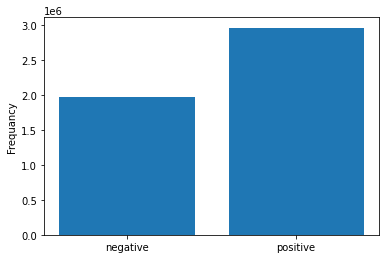

In [20]:
#plot to make sure the distrubution is the balanced
plt.figure()

plt.ylabel('Frequancy')
plt.xticks([1, 0],['positive','negative'])

plt.bar([1, 0],df_review['stars'].value_counts())

In [21]:
#printing the precentage of positive entries
print('distrubution (precentage of positive data): {} %'.format((df_review['stars'].sum(axis=0)/df_review.shape[0])*100))

distrubution (precentage of positive data): 60.0 %


In [22]:
df_review

,stars,text,lengths
0,1,Konkus was excellent start to finish!! Our sal...,39
1,1,"Very tasty food, more authentic than normal Am...",26
2,1,Great place to have a big bowl of noodles in y...,395
3,1,Get the chimichanga with EXTRA sauce...to die ...,19
4,1,Great staff- makes it all the better. We enjoy...,106
...,...,...,...
4935440,0,Abysmal. A 40 minute wait for soupy egg whites...,64
4935441,0,So I show up to rent. No line...Fabulous! He f...,287
4935442,0,Surprised to see all these great reviews... I ...,169
4935443,0,"Like some of you, I've frequented Starbucks to...",207


avarege length is 118.3930897821777


<AxesSubplot:ylabel='Frequency'>

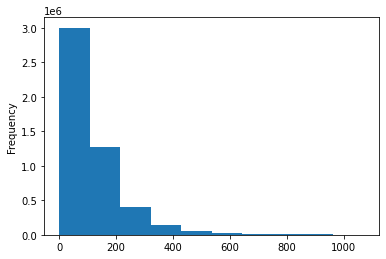

In [23]:
#plotting the length of the reviews
print('avarege length is', df_review['lengths'].mean())

df_review['lengths'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

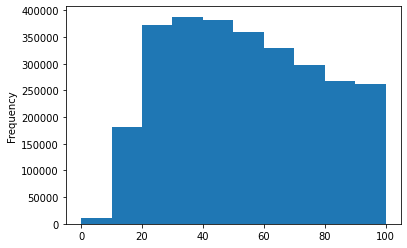

In [24]:
#plotting the length of the reviews with a range of 100
df_review['lengths'].plot.hist(range=(0,100))

In [25]:
df_review.drop('lengths', axis=1, inplace=True)
df_review.head(5)

,stars,text
0,1,Konkus was excellent start to finish!! Our sal...
1,1,"Very tasty food, more authentic than normal Am..."
2,1,Great place to have a big bowl of noodles in y...
3,1,Get the chimichanga with EXTRA sauce...to die ...
4,1,Great staff- makes it all the better. We enjoy...


# saving the modified data:

In [26]:
#changing 1/0 to positive/negative
df_review['stars'] = df_review['stars'].apply(lambda x:"positive" if x == 1 else 'negative' if x == 0 else None)
df_review.dropna(axis=0, inplace=True)
df_review.head(5)

,stars,text
0,positive,Konkus was excellent start to finish!! Our sal...
1,positive,"Very tasty food, more authentic than normal Am..."
2,positive,Great place to have a big bowl of noodles in y...
3,positive,Get the chimichanga with EXTRA sauce...to die ...
4,positive,Great staff- makes it all the better. We enjoy...


In [27]:
#saving the data to be used later on
df_review.to_pickle('yelp_balanced_60_positive.pkl')
df_review.to_csv('yelp_balanced_60_positive.csv')

In [29]:
df1 = pd.read_pickle('yelp_balanced_60_positive.pkl')
df1.head(10)

,stars,text
0,positive,Konkus was excellent start to finish!! Our sal...
1,positive,"Very tasty food, more authentic than normal Am..."
2,positive,Great place to have a big bowl of noodles in y...
3,positive,Get the chimichanga with EXTRA sauce...to die ...
4,positive,Great staff- makes it all the better. We enjoy...
5,positive,"I was in Portland..so I had to have seafood, a..."
6,positive,We have gone here as a family since it opened ...
7,positive,Despite it's location within the southern sliv...
8,positive,This place is worth the trip!!! My family was ...
9,positive,"I buy Bike stuff here, I ride my bike to buy b..."
